## TOC:
* [1. Generate Images of All Fluorinated Compounds with Atom Indices](#1)
* [2. Generate SDF Files for All Fluorinated Compounds](#2)
* [3. Pre-analysis of the 19F NMR Dataset](#3)
* [4. 3D feature Set](#4)
* [5. 2D feature Sets](#5)
* [6. Train Test Split](#6)
* [7. Ridge Model with 3D Feature Set](#7)
    * [7.1 Spatially Neighboring atoms = 3 ](#7.1)
    * [7.2 Spatially Neighboring atoms = 5 ](#7.2)
    * [7.3 Spatially Neighboring atoms = 7 ](#7.3)
    * [7.4 Spatially Neighboring atoms = 10](#7.4)
    * [7.5 Compare Model Performance using the Validation dataset](#7.5)
    * [7.6 Feature Importance Analysis](#7.6)
* [8. Ridge Model with 2D Feature Set](#8)
    * [8.1 Neighboring Spheres = 2](#8.1)
    * [8.2 Neighboring Spheres = 3](#8.2)
    * [8.3 Neighboring Spheres = 4](#8.3)
    * [8.4 Neighboring Spheres = 5](#8.4)
    * [8.5 Compare Model Performance using the Validation dataset](#8.5)
    * [8.6 Feature Importance Analysis](#8.6)

In [1]:
import os
import sys
import pickle
import pandas as pd
import numpy as np
from IPython.display import Image

# https://www.rdkit.org/
# https://github.com/rdkit/rdkit
from rdkit import Chem
from rdkit.Chem import Draw

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

# plot
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns


RANDOM_STATE = 1

src_path = os.path.join("..")
if src_path not in sys.path:
    sys.path.append(src_path)

src_path = os.path.join("..", "src")
if src_path not in sys.path:
    sys.path.append(src_path)

src_path = os.path.join("..", "external", "HOSE_code_generator")
if src_path not in sys.path:
    sys.path.append(src_path)

from src import (
    common,
    atomic_features_2D,
    atomic_features_3D,
)  # Some common methods I defined

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 100)

# I. Generate Images of All Fluorinated Compounds with Atom Indices<a class="anchor" id="1"></a>

In [2]:
data_path = os.path.join("..", "dataset", "Raw_PFAS 19F NMR spectra data.csv")

All_fluorinated_compounds = pd.read_csv(data_path, index_col=0)
All_fluorinated_compounds.head(3)

,Group,IsPFAS(haveCF2),CAS,Compound name,Code,Solvent_used_for_NMR,Source,Note,SMILES,Internal Standard,FluorineInConjSystem,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70
0,Per- and polyfluorinated carboxylic acids,True,NaN,perfluoropropionic acid,COOH_1,CDCl3,100+PFAS,NaN,O=C(O)C(F)(F)C(F)(F)F,NaN,0.0,NaN,NaN,NaN,NaN,-122.45,-122.45,NaN,-83.40,-83.40,-83.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Per- and polyfluorinated carboxylic acids,True,NaN,perfluorobutanoic acid,COOH_2,CDCl3,100+PFAS,NaN,O=C(O)C(F)(F)C(F)(F)C(F)(F)F,NaN,0.0,NaN,NaN,NaN,NaN,-119.78,-119.78,NaN,-127.39,-127.39,NaN,-81.14,-81.14,-81.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Per- and polyfluorinated carboxylic acids,True,NaN,perfluoropentanoic acid,COOH_3,CDCl3,100+PFAS,NaN,O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,NaN,0.0,NaN,NaN,NaN,NaN,-119.41,-119.41,NaN,-123.99,-123.99,NaN,-126.26,-126.26,NaN,-81.19,-81.19,-81.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Transform SMILES to canonical SMILES
All_fluorinated_compounds["SMILES"] = common.canonical_smiles(
    All_fluorinated_compounds["SMILES"]
)

# Transform SMILES to mol
All_fluorinated_compounds["mols"] = [
    Chem.MolFromSmiles(smi) for smi in All_fluorinated_compounds["SMILES"]
]

# Transform SMILES to 3D conformation
All_fluorinated_compounds["3D_Conformation"] = [
    atomic_features_3D.Transform_SMILE_to_3D_conformation(smi)
    for smi in All_fluorinated_compounds["SMILES"]
]

for mol in All_fluorinated_compounds["mols"]:
    for i, atom in enumerate(mol.GetAtoms()):
        atom.SetProp("molAtomMapNumber", str(atom.GetIdx()))

        # Find the corresponding 'Code' for the current molecule
        fluorinated_compounds_code = All_fluorinated_compounds.loc[
            All_fluorinated_compounds["mols"] == mol, "Code"
        ].values[0]

        # Save the molecule image with the Code as part of the file name
        # First check if the file already exists
        # If the file doesn't exist, create the image
        file_path = os.path.join(
            "..", "dataset", "pictures", f"{fluorinated_compounds_code}.png"
        )
        if not os.path.exists(file_path):
            Draw.MolToFile(mol, file_path, size=(600, 400))

[10:29:40] UFFTYPER: Warning: hybridization set to SP3 for atom 6


# II. Generate SDF Files for All Fluorinated Compounds <a class="anchor" id="2"></a>

In [4]:
for index, row in All_fluorinated_compounds.iterrows():
    try:
        # Use the 'Code' value as the filename, create the sdf file if it doesn't exist
        file_path = os.path.join("..", "dataset", "sdf", f"{row['Code']}.sdf")
        if not os.path.exists(file_path):
            hmol_3D = row["3D_Conformation"]
            w = Chem.SDWriter(file_path)
            w.write(hmol_3D)
            w.close()
    except Exception as e:
        print(f"Error processing row {index}: {e}")

The atomic properties of the atoms and their nearest neighbors in 3D space were generated using the CDK package, implemented in Java, based on the generated 3D SDF structure. This step utilized an open-source project available at https://github.com/tsajed/nmr-pred.git.

Generated data files were stored in the files: './All fluorinated_compounds/neighbors' and'./All fluorinated_compounds/descriptors'.

# III. Pre-analysis of the 19F NMR Dataset<a class="anchor" id="3"></a>

In [5]:
file_path = os.path.join("..", "dataset", "Raw_PFAS 19F NMR spectra data.csv")
All_fluorinated_compounds = pd.read_csv(file_path, index_col=0)
All_fluorinated_compounds.head(5)

,Group,IsPFAS(haveCF2),CAS,Compound name,Code,Solvent_used_for_NMR,Source,Note,SMILES,Internal Standard,FluorineInConjSystem,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70
0,Per- and polyfluorinated carboxylic acids,True,NaN,perfluoropropionic acid,COOH_1,CDCl3,100+PFAS,NaN,O=C(O)C(F)(F)C(F)(F)F,NaN,0.0,NaN,NaN,NaN,NaN,-122.45,-122.45,NaN,-83.40,-83.40,-83.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Per- and polyfluorinated carboxylic acids,True,NaN,perfluorobutanoic acid,COOH_2,CDCl3,100+PFAS,NaN,O=C(O)C(F)(F)C(F)(F)C(F)(F)F,NaN,0.0,NaN,NaN,NaN,NaN,-119.78,-119.78,NaN,-127.39,-127.39,NaN,-81.14,-81.14,-81.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Per- and polyfluorinated carboxylic acids,True,NaN,perfluoropentanoic acid,COOH_3,CDCl3,100+PFAS,NaN,O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,NaN,0.0,NaN,NaN,NaN,NaN,-119.41,-119.41,NaN,-123.99,-123.99,NaN,-126.26,-126.26,NaN,-81.19,-81.19,-81.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Per- and polyfluorinated carboxylic acids,True,NaN,perfluorohexanoic acid,COOH_4,CDCl3,100+PFAS,NaN,O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,NaN,0.0,NaN,NaN,NaN,NaN,-119.23,-119.23,NaN,-122.87,-122.87,NaN,-123.25,-123.25,NaN,-126.44,-126.44,NaN,-81.06,-81.06,-81.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Per- and polyfluorinated carboxylic acids,True,NaN,perfluoroheptanoic acid,COOH_5,CDCl3,100+PFAS,NaN,O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,NaN,0.0,NaN,NaN,NaN,NaN,-119.14,-119.14,NaN,-122.01,-122.01,NaN,-122.99,-122.99,NaN,-122.99,-122.99,NaN,-126.29,-126.29,NaN,-80.96,-80.96,-80.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Columns labeled 1 through 70 represent atom indices. If the atom indice corresponding to a fluorine (F) atom, the chemical shift values for the atom will be displayed in that column.

**Number of PFAS in our dataset**

In [6]:
PFAS_num = (All_fluorinated_compounds["IsPFAS(haveCF2)"] == True).sum()
print(f"Number of PFAS in the dataset is {PFAS_num}")
print(
    f"Number of fluorinated compounds in the dataset is {len(All_fluorinated_compounds)}"
)

Number of PFAS in the dataset is 213
Number of fluorinated compounds in the dataset is 647


In [7]:
duplicates_compounds = All_fluorinated_compounds[
    All_fluorinated_compounds["SMILES"].duplicated()
]["SMILES"].values
num_duplicated_compounds = len(duplicates_compounds)
print(
    f"There are {num_duplicated_compounds} compounds that have been reported multiple times in the dataset from different sources."
)

There are 38 compounds that have been reported multiple times in the dataset from different sources.


In [8]:
duplicated_fluorinated_compounds = All_fluorinated_compounds[
    All_fluorinated_compounds["SMILES"].isin(duplicates_compounds)
]

solvents = duplicated_fluorinated_compounds["Solvent_used_for_NMR"].unique()
print(
    f"The solvents used for NMR experiments with these duplicated fluorinated compounds: {solvents}"
)

The solvents used for NMR experiments with these duplicated fluorinated compounds: ['CDCl3' 'CD3OD' 'DMSO' 'D2O']


**Error Distribution in 19F NMR Data of the Same Fluorinated Compound from Different Sources**

In [9]:
NMR_shift_duplicated = pd.DataFrame()
all_errors = []
for SMILES in duplicated_fluorinated_compounds["SMILES"].values:
    peaks = duplicated_fluorinated_compounds[
        duplicated_fluorinated_compounds["SMILES"] == SMILES
    ]

    compound_name = peaks["Compound name"]
    code = peaks["Code"]
    peaks = peaks.drop(
        [
            "Group",
            "IsPFAS(haveCF2)",
            "CAS",
            "Compound name",
            "Source",
            "Note",
            "SMILES",
            "Internal Standard",
            "FluorineInConjSystem",
        ],
        axis=1,
    )
    peaks = peaks.dropna(axis=1, how="any")
    peaks = peaks.reset_index(drop=True)

    only_peaks = peaks.drop(["Code", "Solvent_used_for_NMR"], axis=1)
    for col in only_peaks:
        only_peaks[col] = pd.to_numeric(only_peaks[col])
    errors = only_peaks.max() - only_peaks.min()
    all_errors.extend(errors.values)

    peaks_melted = pd.melt(
        peaks,
        id_vars=["Code", "Solvent_used_for_NMR"],
        var_name="index_suffix",
        value_name="values",
    )
    peaks_melted["index"] = peaks_melted["Code"] + "_" + peaks_melted["index_suffix"]
    df_transformed = peaks_melted[
        ["index", "values", "Solvent_used_for_NMR", "index_suffix"]
    ].set_index("index")
    df_transformed["SMILES"] = SMILES
    NMR_shift_duplicated = pd.concat([NMR_shift_duplicated, df_transformed])

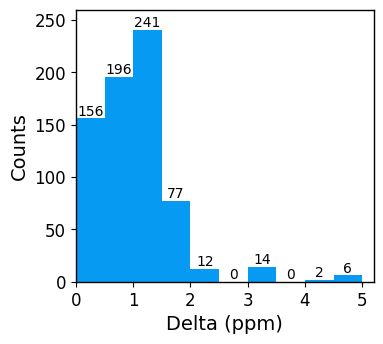

In [10]:
"""Plot the histogram of the errors"""
cm = 1 / 2.54  # centimeters in inches

# Create the figure and axes with specified size
fig, ax = plt.subplots(figsize=(10 * cm, 9 * cm))  # 8 cm x 8 cm

# Plot the histogram
counts, edges, bars = ax.hist(all_errors, bins=10, color="#069AF3")

# Set border (edge) line width
ax.spines["top"].set_linewidth(1)  # Top border
ax.spines["right"].set_linewidth(1)  # Right border
ax.spines["bottom"].set_linewidth(1)  # Bottom border
ax.spines["left"].set_linewidth(1)  # Left border

# Set axis titles and tick label font sizes
ax.set_xlabel("Delta (ppm)", fontsize=14)  # Replace with your label
ax.set_ylabel("Counts", fontsize=14)  # Replace with your label
ax.tick_params(axis="x", labelsize=12)  # X-axis numbers font size
ax.tick_params(axis="y", labelsize=12)  # Y-axis numbers font size

# Add bar labels
for b in ax.containers:
    ax.bar_label(b)

ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_ylim([0, 260])
ax.set_xlim([0, 5.2])
# Create the legend with specified font size and line width
# legend = ax.legend(loc='best', fontsize=12)  # Legend with font size 12
# for legobj in legend.legendHandles:
#     legobj.set_linewidth(2)  # Set legend line width

# Show the plot
plt.tight_layout()
plt.show()

Figure. Error Distribution in 19F NMR Data of the Same Fluorinated Compound from Different Sources

We examined the fluorinated compounds data with deviations exceeding 2.5 ppm and found that these deviations primarily arise from reporting errors rather than specific solvent differences. Therefore, the influence of solvents on 19F NMR appears to be negligible.

In [11]:
temp_fluorinated_compounds = All_fluorinated_compounds.drop(
    [
        "IsPFAS(haveCF2)",
        "Compound name",
        "Code",
        "Solvent_used_for_NMR",
        "SMILES",
        "FluorineInConjSystem",
        "Group",
        "CAS",
        "Source",
        "Note",
        "Internal Standard",
    ],
    axis=1,
)

for col in temp_fluorinated_compounds.columns:
    temp_fluorinated_compounds[col] = pd.to_numeric(
        temp_fluorinated_compounds[col], errors="coerce"
    )

max_values = temp_fluorinated_compounds.max()
min_values = temp_fluorinated_compounds.min()

temp_df = pd.DataFrame()
temp_df["max"] = max_values
temp_df["min"] = min_values

upper_range_of_chemical_shift = temp_df.max().max()
lower_range_of_chemical_shift = temp_df.min().min()

print(
    f"The range of 19F NMR shift values in our dataset is from {lower_range_of_chemical_shift} to {upper_range_of_chemical_shift}"
)

The range of 19F NMR shift values in our dataset is from -268.0 to -5.1


**Data distribution in our dataset**

In [12]:
get_2d_descriptors = atomic_features_2D.getAtomicDescriptorsFrom2DNeighbors()
all_fluorinated_compounds_temp = get_2d_descriptors.getDescriptorsFromDataset(
    All_fluorinated_compounds, 2
)
all_fluorinated_compounds_temp.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,NMR_Peaks
4_COOH_1,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,2.0,0.0,3.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,-122.45
5_COOH_1,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,2.0,0.0,3.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,-122.45
7_COOH_1,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,-83.4


In [13]:
all_fluorinated_compounds_temp["NMR_Peaks"] = all_fluorinated_compounds_temp[
    "NMR_Peaks"
].apply(pd.to_numeric, errors="coerce")
num_datapoints = ~all_fluorinated_compounds_temp["NMR_Peaks"].isna()
num_datapoints = num_datapoints.sum()
num_datapoints

3497

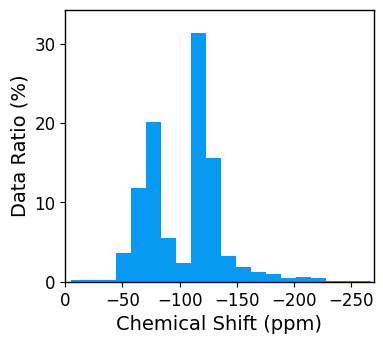

In [14]:
#  Single fluorine chemical shifts, which encompass vinylic, aryl, and saturated aliphatic fluorine substituents
CF_range = [-70, -238]
CF2_range = [-80, -130]
CF3_range = [-52, -87]

cm = 1 / 2.54  # centimeters in inches
# Create the figure and axes with specified size
fig, ax = plt.subplots(figsize=(10 * cm, 9 * cm))  # 8 cm x 8 cm

color1 = "C4"
color2 = "C9"
color3 = "C2"

# ax.fill_betweenx(y=[0, 1200], x1=CF_range[0], x2=CF_range[1], color=color1, alpha=0.1)
# ax.fill_betweenx(y=[0, 1120], x1=CF2_range[0], x2=CF2_range[1], color=color2, alpha=0.1)
# ax.fill_betweenx(y=[0, 1040], x1=CF3_range[0], x2=CF3_range[1], color=color3, alpha=0.1)

# ax.hlines(y=1200, xmin=CF_range[1], xmax=CF_range[0], color=color1, linestyle='-', linewidth=2)
# ax.hlines(y=1120, xmin=CF2_range[1], xmax=CF2_range[0], color=color2, linestyle='-', linewidth=2)
# ax.hlines(y=1040, xmin=CF3_range[1], xmax=CF3_range[0], color=color3, linestyle='-', linewidth=2)

# ax.text((CF_range[0] + CF_range[1]) / 2, 1200 + 12, 'CF', color=color1, ha='center')
# ax.text((CF2_range[0] + CF2_range[1]) / 2, 1120 + 12, 'CF₂', color=color2, ha='center')
# ax.text((CF3_range[0] + CF3_range[1]) / 2, 1040 + 12, 'CF₃', color=color3, ha='center')


# Plot the histogram
counts, edges, bars = ax.hist(
    all_fluorinated_compounds_temp["NMR_Peaks"], bins=20, color="#069AF3"
)

# Set border (edge) line width
ax.spines["top"].set_linewidth(1)  # Top border
ax.spines["right"].set_linewidth(1)  # Right border
ax.spines["bottom"].set_linewidth(1)  # Bottom border
ax.spines["left"].set_linewidth(1)  # Left border

# Set axis titles and tick label font sizes
ax.set_xlabel("Chemical Shift (ppm)", fontsize=14)  # Replace with your label
ax.set_ylabel("Data Ratio (%)", fontsize=14)  # Replace with your label
ax.tick_params(axis="x", labelsize=12)  # X-axis numbers font size
ax.tick_params(axis="y", labelsize=12)  # Y-axis numbers font size

y_ticks_label = list(map(lambda x: x * 3497, [0, 0.1, 0.2, 0.3]))
ax.set_yticks(y_ticks_label)
y_vals = ax.get_yticks()
ax.set_yticklabels([f"{100*y/3497:.0f}" for y in y_vals])

# # Add bar labels
# for b in ax.containers:
#     ax.bar_label(b)

ax.set_xticks([0, -50, -100, -150, -200, -250])
ax.set_ylim([0, 1200])
ax.set_xlim([0, -270])

# Show the plot
plt.tight_layout()
plt.show()

# IV. 3D feature set <a class="anchor" id="4"></a>
Obtain Atomic Descriptors from Neighboring Atoms in 3D Space 

**Value range for each atomic descriptors in our dataset**

In [15]:
# All fluorinated compounds
all_fluorinated_compounds_w_Desc = atomic_features_3D.Combine_descriptors(
    All_fluorinated_compounds, neighbor_num=5, with_additional_info=False
)
all_fluorinated_compounds_w_Desc

descriptor_list = [
    "AtomDegreeDescriptor",
    "AtomHybridizationDescriptor",
    "AtomHybridizationVSEPRDescriptor",
    "AtomValenceDescriptor",
    "BondsToAtomDescriptor",
    "CovalentRadiusDescriptor",
    "DistanceToAtomDescriptor",
    "EffectiveAtomPolarizabilityDescriptor",
    "IPAtomicHOSEDescriptor",
    "InductiveAtomicHardnessDescriptor",
    "InductiveAtomicSoftnessDescriptor",
    "PartialPiChargeDescriptor",
    "PartialSigmaChargeDescriptor",
    "PartialTChargeMMFF94Descriptor",
    "PartialTChargePEOEDescriptor",
    "PeriodicTablePositionDescriptor",
    "PiElectronegativityDescriptor",
]
for descriptor in descriptor_list:
    AtomDescriptor = all_fluorinated_compounds_w_Desc[
        [col for col in all_fluorinated_compounds_w_Desc.columns if descriptor in col]
    ]
    print(
        f"Value range of  [{descriptor}] in our dataset is {AtomDescriptor.min().min()} - {AtomDescriptor.max().max()}; "
    )

Value range of  [AtomDegreeDescriptor] in our dataset is 0.0 - 4.0; 
Value range of  [AtomHybridizationDescriptor] in our dataset is 0.0 - 4.0; 
Value range of  [AtomHybridizationVSEPRDescriptor] in our dataset is 0.0 - 4.0; 
Value range of  [AtomValenceDescriptor] in our dataset is 1.0 - 7.0; 
Value range of  [BondsToAtomDescriptor] in our dataset is 0.0 - 16.0; 
Value range of  [CovalentRadiusDescriptor] in our dataset is 0.72 - 2.03; 
Value range of  [DistanceToAtomDescriptor] in our dataset is 0.0 - 16.157713831170547; 
Value range of  [EffectiveAtomPolarizabilityDescriptor] in our dataset is 1.804 - 74.55199999999996; 
Value range of  [IPAtomicHOSEDescriptor] in our dataset is 0.0 - 13.0; 
Value range of  [InductiveAtomicHardnessDescriptor] in our dataset is 0.1138288354617123 - 4.814551206527448; 
Value range of  [InductiveAtomicSoftnessDescriptor] in our dataset is 0.2077036793469399 - 8.785120184563088; 
Value range of  [PartialPiChargeDescriptor] in our dataset is -4.338243413

# V. 2D feature sets <a class="anchor" id="5"></a>
We decide to use 'atom_mass', 'atom_hybridization', 'atom_isAromatic', 'atom_degree', 'atom_valence', 'atom_explicit_valence', 'atom_isInRing' as atomic features in the 2D feature set.

In [16]:
code = "aromatics_7"
smiles = All_fluorinated_compounds[All_fluorinated_compounds["Code"] == code][
    "SMILES"
].values
atom_info = atomic_features_2D.show_atomic_features_of_atoms(smiles[0])
atom_info

,mass,hybridization,isAromatic,degree,valence,explicit_valence,isInRing
0,18.998,3,0,1,1,1,0
1,12.011,3,0,4,4,4,0
2,18.998,3,0,1,1,1,0
3,18.998,3,0,1,1,1,0
4,12.011,2,1,3,4,4,1
...,...,...,...,...,...,...,...
6,12.011,2,1,2,4,3,1
7,12.011,2,1,3,4,4,1
8,35.453,3,0,1,1,1,0
9,12.011,2,1,2,4,3,1


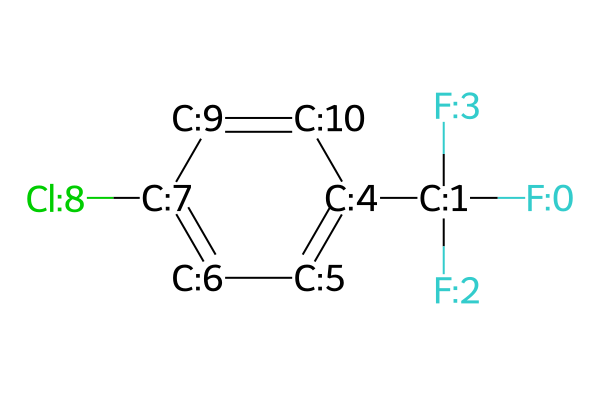

In [17]:
filepath = os.path.join("..", "dataset", "pictures", f"{code}.png")

Image(filename=filepath)

**Value range for each atomic descriptors in our dataset**

In [18]:
all_fluorinated_compounds_w_2D_feature_set = (
    get_2d_descriptors.getDescriptorsFromDataset(
        All_fluorinated_compounds, num_spheres=5
    )
)
all_fluorinated_compounds_w_2D_feature_set.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,NMR_Peaks
4_COOH_1,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,2.0,0.0,3.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,15.999,2.0,0.0,1.0,2.0,2.0,0.0,15.999,2.0,0.0,1.0,2.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.45
5_COOH_1,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,2.0,0.0,3.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,15.999,2.0,0.0,1.0,2.0,2.0,0.0,15.999,2.0,0.0,1.0,2.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.45
7_COOH_1,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,2.0,0.0,3.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-83.4


In [19]:
feature_set = all_fluorinated_compounds_w_2D_feature_set.drop(["NMR_Peaks"], axis=1)

descriptor_list = [
    "mass",
    "hybridization",
    "isAromatic",
    "degree",
    "valence",
    "explicit_valence",
    "isInRing",
]
nums = [1, 2, 3, 4, 5, 6, 0]

for num, descriptor in zip(nums, descriptor_list):
    AtomDescriptor = feature_set[
        [col for col in feature_set.columns if (int(col) + 1) % 7 == num]
    ]
    print(
        f"Value range of  [{descriptor}] in our dataset is {AtomDescriptor.min().min()} - {AtomDescriptor.max().max()}; "
    )

Value range of  [mass] in our dataset is 12.011 - 126.904; 
Value range of  [hybridization] in our dataset is 2.0 - 3.0; 
Value range of  [isAromatic] in our dataset is 0.0 - 1.0; 
Value range of  [degree] in our dataset is 1.0 - 4.0; 
Value range of  [valence] in our dataset is 1.0 - 6.0; 
Value range of  [explicit_valence] in our dataset is 1.0 - 6.0; 
Value range of  [isInRing] in our dataset is 0.0 - 1.0; 


# VI. Train Test Split<a class="anchor" id="6"></a>

In [20]:
data_path = os.path.join("..", "dataset", "Raw_PFAS 19F NMR spectra data.csv")

All_fluorinated_compounds = pd.read_csv(data_path, index_col=0)

# Train, validation, test dataset split
train_fluorinated_compounds, test_fluorinated_compounds = train_test_split(
    All_fluorinated_compounds, test_size=0.15, random_state=RANDOM_STATE, shuffle=True
)
train_fluorinated_compounds, vali_fluorinated_compounds = train_test_split(
    train_fluorinated_compounds, test_size=0.2, random_state=RANDOM_STATE, shuffle=True
)
print(
    f"Number of fluorinated_compounds in the train dataset: {train_fluorinated_compounds.shape[0]}"
)
print(
    f"Number of fluorinated_compounds in the validation dataset: {vali_fluorinated_compounds.shape[0]}"
)
print(
    f"Number of fluorinated_compounds in the test dataset: {test_fluorinated_compounds.shape[0]}"
)

Number of fluorinated_compounds in the train dataset: 439
Number of fluorinated_compounds in the validation dataset: 110
Number of fluorinated_compounds in the test dataset: 98


In [21]:
# Transform the column names of the DataFrame to integers where possible and keep them as strings otherwise
train_fluorinated_compounds.columns = [
    common.convert_column_name(name) for name in train_fluorinated_compounds.columns
]
vali_fluorinated_compounds.columns = [
    common.convert_column_name(name) for name in vali_fluorinated_compounds.columns
]
test_fluorinated_compounds.columns = [
    common.convert_column_name(name) for name in test_fluorinated_compounds.columns
]

# VII. Ridge model with 3D feature set <a class="anchor" id="7"></a>

## 7.1 Spatially Neighboring atoms = 3 <a class="anchor" id="7.1"></a>
**Combine fluorinated_compounds data with Descriptors**

In [22]:
train_fluorinated_compounds_w_Desc = atomic_features_3D.Combine_descriptors(
    train_fluorinated_compounds, neighbor_num=3, with_additional_info=True
)

print(
    f"Shape of the train_fluorinated_compounds_w_Desc: {train_fluorinated_compounds_w_Desc.shape}"
)

print(
    f"Shape of the train_fluorinated_compounds_w_Desc: {train_fluorinated_compounds_w_Desc.shape}"
)
train_fluorinated_compounds_w_Desc.rename_axis(
    "atomCode_fluorinated_compoundsCode", inplace=True
)

# Save the table to a csv file
file_path = os.path.join("..", "artifacts", "temp", f"train_dataset_3D_neighbors3.csv")
train_fluorinated_compounds_w_Desc.to_csv(file_path, encoding="UTF-8")
train_fluorinated_compounds_w_Desc.head(5)

Shape of the train_fluorinated_compounds_w_Desc: (2351, 82)
Shape of the train_fluorinated_compounds_w_Desc: (2351, 82)


,NMR_Peaks,SMILES_self,AtomDegreeDescriptor-aNeg_self,AtomHybridizationDescriptor-aHyb_self,AtomHybridizationVSEPRDescriptor-hybr_self,AtomValenceDescriptor-val_self,BondsToAtomDescriptor-bondsToAtom_self,CovalentRadiusDescriptor-covalentRadius_self,DistanceToAtomDescriptor-distanceToAtom_self,EffectiveAtomPolarizabilityDescriptor-effAtomPol_self,IPAtomicHOSEDescriptor-ipAtomicHOSE_self,InductiveAtomicHardnessDescriptor-indAtomHardnesss_self,InductiveAtomicSoftnessDescriptor-indAtomSoftness_self,PartialPiChargeDescriptor-pepe_self,PartialSigmaChargeDescriptor-partialSigmaCharge_self,PartialTChargeMMFF94Descriptor-partialTCMMFF94_self,PartialTChargePEOEDescriptor-pepeT_self,PeriodicTablePositionDescriptor-periodicTablePosition_self,PiElectronegativityDescriptor-elecPiA_self,level_0_neighbor1,index_neighbor1,SMILES_neighbor1,AtomDegreeDescriptor-aNeg_neighbor1,AtomHybridizationDescriptor-aHyb_neighbor1,AtomHybridizationVSEPRDescriptor-hybr_neighbor1,AtomValenceDescriptor-val_neighbor1,BondsToAtomDescriptor-bondsToAtom_neighbor1,CovalentRadiusDescriptor-covalentRadius_neighbor1,DistanceToAtomDescriptor-distanceToAtom_neighbor1,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor1,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor1,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor1,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor1,PartialPiChargeDescriptor-pepe_neighbor1,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor1,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor1,PartialTChargePEOEDescriptor-pepeT_neighbor1,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor1,PiElectronegativityDescriptor-elecPiA_neighbor1,level_0_neighbor2,index_neighbor2,SMILES_neighbor2,AtomDegreeDescriptor-aNeg_neighbor2,AtomHybridizationDescriptor-aHyb_neighbor2,AtomHybridizationVSEPRDescriptor-hybr_neighbor2,AtomValenceDescriptor-val_neighbor2,BondsToAtomDescriptor-bondsToAtom_neighbor2,CovalentRadiusDescriptor-covalentRadius_neighbor2,DistanceToAtomDescriptor-distanceToAtom_neighbor2,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor2,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor2,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor2,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor2,PartialPiChargeDescriptor-pepe_neighbor2,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor2,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor2,PartialTChargePEOEDescriptor-pepeT_neighbor2,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor2,PiElectronegativityDescriptor-elecPiA_neighbor2,level_0_neighbor3,index_neighbor3,SMILES_neighbor3,AtomDegreeDescriptor-aNeg_neighbor3,AtomHybridizationDescriptor-aHyb_neighbor3,AtomHybridizationVSEPRDescriptor-hybr_neighbor3,AtomValenceDescriptor-val_neighbor3,BondsToAtomDescriptor-bondsToAtom_neighbor3,CovalentRadiusDescriptor-covalentRadius_neighbor3,DistanceToAtomDescriptor-distanceToAtom_neighbor3,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor3,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor3,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor3,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor3,PartialPiChargeDescriptor-pepe_neighbor3,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor3,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor3,PartialTChargePEOEDescriptor-pepeT_neighbor3,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor3,PiElectronegativityDescriptor-elecPiA_neighbor3,SMILES,Compound name,Solvent_used_for_NMR
atomCode_fluorinated_compoundsCode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4_ether_12,-119.9,F,1.0,3.0,3.0,7.0,3.0,0.72,2.843026,3.725625,0.0,1.268572,0.788288,0.0,-0.187374,-0.317,-0.187374,2.0,4.742414,0,3,C,4.0,3.0,3.0,4.0,2.0,0.77,2.45147,6.09125,0.0,0.777693,1.285855,0.0,0.404278,0.729,0.404278,2.0,0.0,1,5,F,1.0,3.0,3.0,7.0,3.0,0.72,3.521411,3.725625,0.0,1.273949,0.784961,0.0,-0.187374,-0.317,-0.187374,2.0,4.742414,2.0,6,C,4.0,3.0,3

### Data Processing<a class="anchor" id="2.2.2"></a>

We defined several data processing functions in the utils.py file.

In [23]:
train_dataset = train_fluorinated_compounds_w_Desc.copy()

dataset = common.drop_constant_col(train_dataset)
print(
    f"Shape of the training dataset after dropping out columns with constant values: {dataset.shape}"
)

dataset_dropNaN = common.drop_high_ratio_NaN_cols(dataset)
print(
    f"\nShape of the training dataset after dropping out columns with more than 80% values being NaN: {dataset_dropNaN.shape}"
)

# drop rows with NaN values in the 'NMR_Peaks' column
dataset_dropNaN = dataset_dropNaN.dropna(subset=["NMR_Peaks"])
print("\n")
print(f"-----Shape of the dataset after drop rows with NaN NMR peak values------")
print(dataset_dropNaN.shape)

# Convert all columns in df to numeric where possible, keeping non-numeric values unchanged
dataset_dropNaN = dataset_dropNaN.apply(pd.to_numeric, errors="ignore")

print(common.count_non_numeric_values(dataset_dropNaN))

# Drop categorical columns
dataset_dropCat = common.drop_categorical_columns(dataset_dropNaN)

dataset_dropCat, imputer = common.fill_NaN(dataset_dropCat)

file_path = os.path.join("..", "artifacts", "models", "imputer_neighbor3_RidgeCV.pkl")
with open(file_path, "wb") as file:
    pickle.dump(imputer, file)

columns = dataset_dropCat.columns.tolist()
file_path = os.path.join(
    "..", "artifacts", "models", "column_names_neighbor3_RidgeCV.pkl"
)
with open(file_path, "wb") as f:
    pickle.dump(columns, f)

print(f"\n-----Shape of the dataset after pre-processing------")
print(dataset_dropCat.shape)

Shape of the training dataset after dropping out columns with constant values: (2351, 67)

Shape of the training dataset after dropping out columns with more than 80% values being NaN: (2351, 67)


-----Shape of the dataset after drop rows with NaN NMR peak values------
(2281, 67)
Columns with Non-Numeric Values:
SMILES_neighbor2        2281
SMILES_neighbor3        2280
SMILES                  2281
Compound name           2281
Solvent_used_for_NMR    2281
dtype: int64
None

-----Shape of the dataset after pre-processing------
(2281, 62)


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_1625/1148196742.py:20: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  dataset_dropNaN = dataset_dropNaN.apply(pd.to_numeric, errors="ignore")


We examined the fluorinated compounds with NaN values in the 'NMR_Peaks' column. All of these instances were from articles that report the NMR shift for only some of the F atoms in a fluorinated compound.

We remove the rows with NaN values in the 'NMR_Peaks' column.

We also remove columns that have NaN values in it because RidgeCV can not handle NAN values.

### X_train and y_train <a class="anchor" id="2.2.4"></a>

In [24]:
y_train = dataset_dropCat["NMR_Peaks"]
X_train = dataset_dropCat.drop(["NMR_Peaks"], axis=1)

### Scaler <a class="anchor" id="2.2.5"></a>

In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

file_path = os.path.join(
    "..", "artifacts", "models", f"scaler_3d_neighbor3_RidgeCV.pkl"
)
with open(file_path, "wb") as file:
    pickle.dump(scaler, file)

In [26]:
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = X_train.columns
X_train_scaled.index = X_train.index

X_train_scaled

,BondsToAtomDescriptor-bondsToAtom_self,DistanceToAtomDescriptor-distanceToAtom_self,EffectiveAtomPolarizabilityDescriptor-effAtomPol_self,IPAtomicHOSEDescriptor-ipAtomicHOSE_self,InductiveAtomicHardnessDescriptor-indAtomHardnesss_self,InductiveAtomicSoftnessDescriptor-indAtomSoftness_self,PartialPiChargeDescriptor-pepe_self,PartialSigmaChargeDescriptor-partialSigmaCharge_self,PartialTChargeMMFF94Descriptor-partialTCMMFF94_self,PartialTChargePEOEDescriptor-pepeT_self,PiElectronegativityDescriptor-elecPiA_self,index_neighbor1,AtomDegreeDescriptor-aNeg_neighbor1,AtomHybridizationDescriptor-aHyb_neighbor1,AtomHybridizationVSEPRDescriptor-hybr_neighbor1,BondsToAtomDescriptor-bondsToAtom_neighbor1,DistanceToAtomDescriptor-distanceToAtom_neighbor1,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor1,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor1,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor1,PartialPiChargeDescriptor-pepe_neighbor1,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor1,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor1,PartialTChargePEOEDescriptor-pepeT_neighbor1,PiElectronegativityDescriptor-elecPiA_neighbor1,index_neighbor2,AtomDegreeDescriptor-aNeg_neighbor2,AtomHybridizationDescriptor-aHyb_neighbor2,AtomHybridizationVSEPRDescriptor-hybr_neighbor2,AtomValenceDescriptor-val_neighbor2,BondsToAtomDescriptor-bondsToAtom_neighbor2,CovalentRadiusDescriptor-covalentRadius_neighbor2,DistanceToAtomDescriptor-distanceToAtom_neighbor2,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor2,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor2,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor2,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor2,PartialPiChargeDescriptor-pepe_neighbor2,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor2,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor2,PartialTChargePEOEDescriptor-pepeT_neighbor2,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor2,PiElectronegativityDescriptor-elecPiA_neighbor2,index_neighbor3,AtomDegreeDescriptor-aNeg_neighbor3,AtomHybridizationDescriptor-aHyb_neighbor3,AtomHybridizationVSEPRDescriptor-hybr_neighbor3,AtomValenceDescriptor-val_neighbor3,BondsToAtomDescriptor-bondsToAtom_neighbor3,CovalentRadiusDescriptor-covalentRadius_neighbor3,DistanceToAtomDescriptor-distanceToAtom_neighbor3,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor3,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor3,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor3,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor3,PartialPiChargeDescriptor-pepe_neighbor3,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor3,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor3,PartialTChargePEOEDescriptor-pepeT_neighbor3,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor3,PiElectronegativityDescriptor-elecPiA_neighbor3
atomCode_fluorinated_compoundsCode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4_ether_12,-0.817078,-0.822831,0.010760,-0.085895,-0.316418,0.058973,-0.270236,-0.290185,-0.349276,-0.394255,-0.298315,-0.811580,0.409534,0.327539,0.327539,-0.899328,-0.858306,0.035515,-0.255889,0.037280,0.212594,0.230711,0.072163,0.261472,-0.326884,-0.720160,-0.345352,0.313818,0.313818,0.388887,-0.778482,-0.153512,-0.586378,-0.145436,-0.085895,-0.114389,-0.116851,0.00193,-0.412192,-0.374387,-0.139619,-0.081672,-0.191594,-0.568611,1.289714,0.308086,0.308086,-0.984672,-0.667498,0.334409,-0.636704,0.342952,-0.080705,-0.806769,0.678932,-0.013927,1.308088,1.211874,0.810692,-0.110585,-1.143986
5_ether_12,-0.817078,-0.590580,0.010760,-0.085895,-0.304917,0.044078,-0.270236,-0.290185,-0.349276,-0.394255,-0.298315,-0.811580,0.409534,0.327539,0.327539,-0.899328,-0.858306,0.035515,-0.255889,0.037280,0.212594,0.230711,0.072163,0.261472,-0.326884,-0.828810,-0.345352,0.313818,0.313818,0.388887,-0.778482,-0.153512,-0.820738,-0.145436,-0.085895,-0.127695,-0.110416,0.00193,-0.412192,-0.374387,-0.13961

###  Build and Train  RidgeCV model <a class="anchor" id="2.2.6"></a>

In [27]:
# Define a custom RMSE scoring function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


# Use the custom RMSE function with make_scorer
scoring = {
    "mae": "neg_mean_absolute_error",
    "rmse": make_scorer(rmse),  # Custom RMSE scorer
    "r2": "r2",
}

param_grid = {"alpha": [10, 50, 80, 90, 100, 150, 200]}

# Create the Ridge model
ridge = Ridge(fit_intercept=True)

# Initialize GridSearchCV with multiple scoring metrics
grid_search = GridSearchCV(
    estimator=ridge, param_grid=param_grid, cv=5, scoring=scoring, refit="mae"
)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best alpha and results for each metric
best_alpha = grid_search.best_params_["alpha"]
best_scores = grid_search.cv_results_


# Output the best alpha and performance on chosen metric
print(f"Best Alpha: {best_alpha}")

# Print out scoring metrics for the best model
print(f'MAE Score: {np.mean(-best_scores["mean_test_mae"]):.2f}')
print(f'Root Mean Squared Error (RMSE): {np.mean(best_scores["mean_test_rmse"]):.2f}')
print(f'R^2 Score: {np.mean(best_scores["mean_test_r2"]):.2f}')

Best Alpha: 10
MAE Score: 6.26
Root Mean Squared Error (RMSE): 10.23
R^2 Score: 0.90


In [28]:
param_grid = {"alpha": [1, 3, 5, 6, 7, 8, 9, 11, 12, 15]}


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


scoring = {
    "mae": "neg_mean_absolute_error",
    "rmse": make_scorer(rmse),  # Custom RMSE scorer
    "r2": "r2",
}

# Initialize GridSearchCV with multiple scoring metrics
grid_search = GridSearchCV(
    estimator=ridge, param_grid=param_grid, cv=5, scoring=scoring, refit="mae"
)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best alpha and results for each metric
best_alpha = grid_search.best_params_["alpha"]
best_scores = grid_search.cv_results_


# Output the best alpha and performance on chosen metric
print(f"Best Alpha: {best_alpha}")

# Print out scoring metrics for the best model
print(f'MAE Score: {np.mean(-best_scores["mean_test_mae"]):.2f}')

print(f'Root Mean Squared Error (RMSE): {np.mean(best_scores["mean_test_rmse"]):.2f}')
print(f'R^2 Score: {np.mean(best_scores["mean_test_r2"]):.2f}')

Best Alpha: 3
MAE Score: 5.10
Root Mean Squared Error (RMSE): 10.00
R^2 Score: 0.90


In [29]:
best_model = grid_search.best_estimator_
file_path = os.path.join("..", "artifacts", "models", f"RidgeCV_model_neighbor3.pkl")
with open(file_path, "wb") as file:
    pickle.dump(best_model, file)

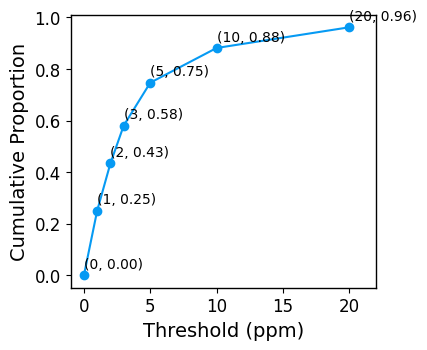

R2 = 0.95
RMSE = 7.41
MAE = 4.462549640628187


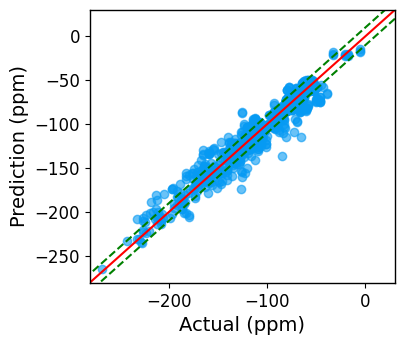

In [30]:
results_table = common.get_results_table(best_model, X_train_scaled, y_train)
common.plot_prediction_performance(results_table)
common.show_results_scatter(results_table)

## 7.2 Spatially Neighboring atoms = 5 <a class="anchor" id="7.2"></a>

In [31]:
train_fluorinated_compounds_w_Desc = atomic_features_3D.Combine_descriptors(
    train_fluorinated_compounds, neighbor_num=5, with_additional_info=True
)
print(
    f"Shape of the train_fluorinated_compounds_w_Desc: {train_fluorinated_compounds_w_Desc.shape}"
)
train_fluorinated_compounds_w_Desc.rename_axis(
    "atomCode_fluorinated_compoundsCode", inplace=True
)

# Save the table to a csv file
file_path = os.path.join("..", "artifacts", "temp", f"train_dataset_3D_neighbors5.csv")
train_fluorinated_compounds_w_Desc.to_csv(file_path, encoding="utf-8")

train_fluorinated_compounds_w_Desc.head(3)

Shape of the train_fluorinated_compounds_w_Desc: (2351, 122)


,NMR_Peaks,SMILES_self,AtomDegreeDescriptor-aNeg_self,AtomHybridizationDescriptor-aHyb_self,AtomHybridizationVSEPRDescriptor-hybr_self,AtomValenceDescriptor-val_self,BondsToAtomDescriptor-bondsToAtom_self,CovalentRadiusDescriptor-covalentRadius_self,DistanceToAtomDescriptor-distanceToAtom_self,EffectiveAtomPolarizabilityDescriptor-effAtomPol_self,IPAtomicHOSEDescriptor-ipAtomicHOSE_self,InductiveAtomicHardnessDescriptor-indAtomHardnesss_self,InductiveAtomicSoftnessDescriptor-indAtomSoftness_self,PartialPiChargeDescriptor-pepe_self,PartialSigmaChargeDescriptor-partialSigmaCharge_self,PartialTChargeMMFF94Descriptor-partialTCMMFF94_self,PartialTChargePEOEDescriptor-pepeT_self,PeriodicTablePositionDescriptor-periodicTablePosition_self,PiElectronegativityDescriptor-elecPiA_self,level_0_neighbor1,index_neighbor1,SMILES_neighbor1,AtomDegreeDescriptor-aNeg_neighbor1,AtomHybridizationDescriptor-aHyb_neighbor1,AtomHybridizationVSEPRDescriptor-hybr_neighbor1,AtomValenceDescriptor-val_neighbor1,BondsToAtomDescriptor-bondsToAtom_neighbor1,CovalentRadiusDescriptor-covalentRadius_neighbor1,DistanceToAtomDescriptor-distanceToAtom_neighbor1,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor1,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor1,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor1,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor1,PartialPiChargeDescriptor-pepe_neighbor1,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor1,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor1,PartialTChargePEOEDescriptor-pepeT_neighbor1,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor1,PiElectronegativityDescriptor-elecPiA_neighbor1,level_0_neighbor2,index_neighbor2,SMILES_neighbor2,AtomDegreeDescriptor-aNeg_neighbor2,AtomHybridizationDescriptor-aHyb_neighbor2,AtomHybridizationVSEPRDescriptor-hybr_neighbor2,AtomValenceDescriptor-val_neighbor2,BondsToAtomDescriptor-bondsToAtom_neighbor2,CovalentRadiusDescriptor-covalentRadius_neighbor2,DistanceToAtomDescriptor-distanceToAtom_neighbor2,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor2,...,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor3,PartialPiChargeDescriptor-pepe_neighbor3,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor3,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor3,PartialTChargePEOEDescriptor-pepeT_neighbor3,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor3,PiElectronegativityDescriptor-elecPiA_neighbor3,level_0_neighbor4,index_neighbor4,SMILES_neighbor4,AtomDegreeDescriptor-aNeg_neighbor4,AtomHybridizationDescriptor-aHyb_neighbor4,AtomHybridizationVSEPRDescriptor-hybr_neighbor4,AtomValenceDescriptor-val_neighbor4,BondsToAtomDescriptor-bondsToAtom_neighbor4,CovalentRadiusDescriptor-covalentRadius_neighbor4,DistanceToAtomDescriptor-distanceToAtom_neighbor4,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor4,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor4,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor4,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor4,PartialPiChargeDescriptor-pepe_neighbor4,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor4,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor4,PartialTChargePEOEDescriptor-pepeT_neighbor4,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor4,PiElectronegativityDescriptor-elecPiA_neighbor4,level_0_neighbor5,index_neighbor5,SMILES_neighbor5,AtomDegreeDescriptor-aNeg_neighbor5,AtomHybridizationDescriptor-aHyb_neighbor5,AtomHybridizationVSEPRDescriptor-hybr_neighbor5,AtomValenceDescriptor-val_neighbor5,BondsToAtomDescriptor-bondsToAtom_neighbor5,CovalentRadiusDescriptor-covalentRadius_neighbor5,DistanceToAtomDescriptor-distanceToAtom_neighbor5,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor5,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor5,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor5,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor5,PartialPiChargeDescriptor-pepe_neighbor5,Par

In [32]:
train_dataset = train_fluorinated_compounds_w_Desc.copy()

dataset = common.drop_constant_col(train_dataset)
print(
    f"Shape of the training dataset after dropping out columns with constant values: {dataset.shape}"
)

dataset_dropNaN = common.drop_high_ratio_NaN_cols(dataset)
print(
    f"\nShape of the training dataset after dropping out columns with more than 80% values being NaN: {dataset_dropNaN.shape}"
)

# drop rows with NaN values in the 'NMR_Peaks' column
dataset_dropNaN = dataset_dropNaN.dropna(subset=["NMR_Peaks"])
print("\n")
print(f"-----Shape of the dataset after drop rows with NaN NMR peak values------")
print(dataset_dropNaN.shape)

# Convert all columns in df to numeric where possible, keeping non-numeric values unchanged
dataset_dropNaN = dataset_dropNaN.apply(pd.to_numeric, errors="ignore")

print(common.count_non_numeric_values(dataset_dropNaN))
# Drop categorical columns

dataset_dropCat = common.drop_categorical_columns(dataset_dropNaN)

dataset_dropCat, imputer = common.fill_NaN(dataset_dropCat)

file_path = os.path.join("..", "artifacts", "models", f"imputer_neighbor5_RidgeCV.pkl")
with open(file_path, "wb") as file:
    pickle.dump(imputer, file)

columns = dataset_dropCat.columns.tolist()
file_path = os.path.join(
    "..", "artifacts", "models", f"column_names_neighbor5_RidgeCV.pkl"
)
with open(file_path, "wb") as f:
    pickle.dump(columns, f)

print(f"\n-----Shape of the dataset after pre-processing------")
print(dataset_dropCat.shape)

Shape of the training dataset after dropping out columns with constant values: (2351, 105)

Shape of the training dataset after dropping out columns with more than 80% values being NaN: (2351, 105)


-----Shape of the dataset after drop rows with NaN NMR peak values------
(2281, 105)
Columns with Non-Numeric Values:
SMILES_neighbor2        2281
SMILES_neighbor3        2280
SMILES_neighbor4        2279
SMILES_neighbor5        2255
SMILES                  2281
Compound name           2281
Solvent_used_for_NMR    2281
dtype: int64
None

-----Shape of the dataset after pre-processing------
(2281, 98)


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_1625/2864594481.py:20: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  dataset_dropNaN = dataset_dropNaN.apply(pd.to_numeric, errors="ignore")


In [33]:
y_train = dataset_dropCat["NMR_Peaks"]
X_train = dataset_dropCat.drop(["NMR_Peaks"], axis=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

file_path = os.path.join(
    "..", "artifacts", "models", f"scaler_3d_neighbors5_RidgeCV.pkl"
)
with open(file_path, "wb") as file:
    pickle.dump(scaler, file)

X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = X_train.columns
X_train_scaled.index = X_train.index

# Define a custom RMSE scoring function


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


# Use the custom RMSE function with make_scorer
scoring = {
    "mae": "neg_mean_absolute_error",
    "rmse": make_scorer(rmse),  # Custom RMSE scorer
    "r2": "r2",
}


param_grid = {"alpha": [10, 50, 80, 90, 100, 150, 200]}

# Create the Ridge model
ridge = Ridge(fit_intercept=True)

# Initialize GridSearchCV with multiple scoring metrics
grid_search = GridSearchCV(
    estimator=ridge, param_grid=param_grid, cv=5, scoring=scoring, refit="mae"
)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best alpha and results for each metric
best_alpha = grid_search.best_params_["alpha"]
best_scores = grid_search.cv_results_


# Output the best alpha and performance on chosen metric
print(f"Best Alpha: {best_alpha}")

# Print out scoring metrics for the best model
print(f'MAE Score: {np.mean(-best_scores["mean_test_mae"]):.2f}')
print(f"Root Mean Squared Error (RMSE): {np.mean(best_scores['mean_test_rmse']):.2f}")
print(f'R^2 Score: {np.mean(best_scores["mean_test_r2"]):.2f}')

Best Alpha: 10
MAE Score: 5.40
Root Mean Squared Error (RMSE): 9.63
R^2 Score: 0.91


In [34]:
param_grid = {"alpha": [1, 3, 5, 6, 7, 8, 9, 11, 12, 15]}

# Initialize GridSearchCV with multiple scoring metrics
grid_search = GridSearchCV(
    estimator=ridge, param_grid=param_grid, cv=5, scoring=scoring, refit="mae"
)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best alpha and results for each metric
best_alpha = grid_search.best_params_["alpha"]
best_scores = grid_search.cv_results_


# Output the best alpha and performance on chosen metric
print(f"Best Alpha: {best_alpha}")

# Print out scoring metrics for the best model
print(f'MAE Score: {np.mean(-best_scores["mean_test_mae"]):.2f}')
print(f"Root Mean Squared Error (RMSE): {np.mean(best_scores['mean_test_rmse']):.2f}")
print(f'R^2 Score: {np.mean(best_scores["mean_test_r2"]):.2f}')

Best Alpha: 1
MAE Score: 4.95
Root Mean Squared Error (RMSE): 10.21
R^2 Score: 0.88


In [35]:
best_model = grid_search.best_estimator_

file_path = os.path.join("..", "artifacts", "models", f"RidgeCV_model_neighbor5.pkl")
with open(file_path, "wb") as file:
    pickle.dump(best_model, file)

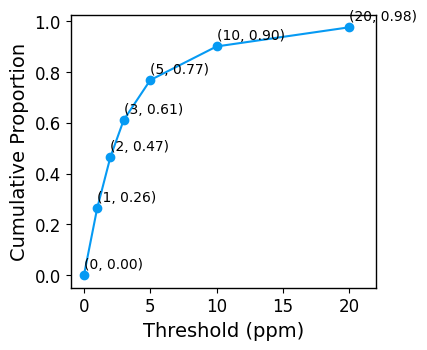

R2 = 0.96
RMSE = 6.62
MAE = 4.003085592778356


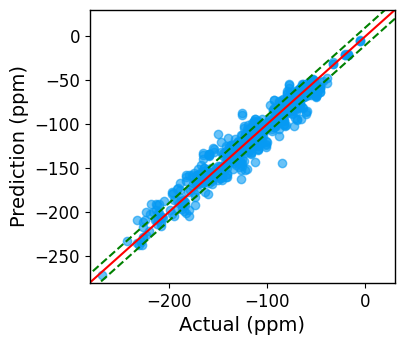

In [36]:
results_table = common.get_results_table(best_model, X_train_scaled, y_train)
common.plot_prediction_performance(results_table)

common.show_results_scatter(results_table)

## ## 7.3 Spatially Neighboring atoms = 7 <a class="anchor" id="7.3"></a>

In [37]:
train_fluorinated_compounds_w_Desc = atomic_features_3D.Combine_descriptors(
    train_fluorinated_compounds, neighbor_num=7, with_additional_info=True
)

print(
    f"Shape of the train_fluorinated_compounds_w_Desc: {train_fluorinated_compounds_w_Desc.shape}"
)

train_fluorinated_compounds_w_Desc.rename_axis(
    "atomCode_fluorinated_compoundsCode", inplace=True
)
file_path = os.path.join("..", "artifacts", "temp", f"train_dataset_3D_neighbors7.csv")
train_fluorinated_compounds_w_Desc.to_csv(file_path, encoding="UTF-8")
train_fluorinated_compounds_w_Desc.head(3)

Shape of the train_fluorinated_compounds_w_Desc: (2351, 162)


,NMR_Peaks,SMILES_self,AtomDegreeDescriptor-aNeg_self,AtomHybridizationDescriptor-aHyb_self,AtomHybridizationVSEPRDescriptor-hybr_self,AtomValenceDescriptor-val_self,BondsToAtomDescriptor-bondsToAtom_self,CovalentRadiusDescriptor-covalentRadius_self,DistanceToAtomDescriptor-distanceToAtom_self,EffectiveAtomPolarizabilityDescriptor-effAtomPol_self,IPAtomicHOSEDescriptor-ipAtomicHOSE_self,InductiveAtomicHardnessDescriptor-indAtomHardnesss_self,InductiveAtomicSoftnessDescriptor-indAtomSoftness_self,PartialPiChargeDescriptor-pepe_self,PartialSigmaChargeDescriptor-partialSigmaCharge_self,PartialTChargeMMFF94Descriptor-partialTCMMFF94_self,PartialTChargePEOEDescriptor-pepeT_self,PeriodicTablePositionDescriptor-periodicTablePosition_self,PiElectronegativityDescriptor-elecPiA_self,level_0_neighbor1,index_neighbor1,SMILES_neighbor1,AtomDegreeDescriptor-aNeg_neighbor1,AtomHybridizationDescriptor-aHyb_neighbor1,AtomHybridizationVSEPRDescriptor-hybr_neighbor1,AtomValenceDescriptor-val_neighbor1,BondsToAtomDescriptor-bondsToAtom_neighbor1,CovalentRadiusDescriptor-covalentRadius_neighbor1,DistanceToAtomDescriptor-distanceToAtom_neighbor1,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor1,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor1,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor1,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor1,PartialPiChargeDescriptor-pepe_neighbor1,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor1,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor1,PartialTChargePEOEDescriptor-pepeT_neighbor1,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor1,PiElectronegativityDescriptor-elecPiA_neighbor1,level_0_neighbor2,index_neighbor2,SMILES_neighbor2,AtomDegreeDescriptor-aNeg_neighbor2,AtomHybridizationDescriptor-aHyb_neighbor2,AtomHybridizationVSEPRDescriptor-hybr_neighbor2,AtomValenceDescriptor-val_neighbor2,BondsToAtomDescriptor-bondsToAtom_neighbor2,CovalentRadiusDescriptor-covalentRadius_neighbor2,DistanceToAtomDescriptor-distanceToAtom_neighbor2,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor2,...,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor5,PartialPiChargeDescriptor-pepe_neighbor5,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor5,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor5,PartialTChargePEOEDescriptor-pepeT_neighbor5,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor5,PiElectronegativityDescriptor-elecPiA_neighbor5,level_0_neighbor6,index_neighbor6,SMILES_neighbor6,AtomDegreeDescriptor-aNeg_neighbor6,AtomHybridizationDescriptor-aHyb_neighbor6,AtomHybridizationVSEPRDescriptor-hybr_neighbor6,AtomValenceDescriptor-val_neighbor6,BondsToAtomDescriptor-bondsToAtom_neighbor6,CovalentRadiusDescriptor-covalentRadius_neighbor6,DistanceToAtomDescriptor-distanceToAtom_neighbor6,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor6,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor6,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor6,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor6,PartialPiChargeDescriptor-pepe_neighbor6,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor6,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor6,PartialTChargePEOEDescriptor-pepeT_neighbor6,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor6,PiElectronegativityDescriptor-elecPiA_neighbor6,level_0_neighbor7,index_neighbor7,SMILES_neighbor7,AtomDegreeDescriptor-aNeg_neighbor7,AtomHybridizationDescriptor-aHyb_neighbor7,AtomHybridizationVSEPRDescriptor-hybr_neighbor7,AtomValenceDescriptor-val_neighbor7,BondsToAtomDescriptor-bondsToAtom_neighbor7,CovalentRadiusDescriptor-covalentRadius_neighbor7,DistanceToAtomDescriptor-distanceToAtom_neighbor7,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor7,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor7,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor7,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor7,PartialPiChargeDescriptor-pepe_neighbor7,Par

In [38]:
train_dataset = train_fluorinated_compounds_w_Desc.copy()

dataset = common.drop_constant_col(train_dataset)
print(
    f"Shape of the training dataset after dropping out columns with constant values: {dataset.shape}"
)

dataset_dropNaN = common.drop_high_ratio_NaN_cols(dataset)
print(
    f"\nShape of the training dataset after dropping out columns with more than 80% values being NaN: {dataset_dropNaN.shape}"
)

# drop rows with NaN values in the 'NMR_Peaks' column
dataset_dropNaN = dataset_dropNaN.dropna(subset=["NMR_Peaks"])
print("\n")
print(f"-----Shape of the dataset after drop rows with NaN NMR peak values------")
print(dataset_dropNaN.shape)

# Convert all columns in df to numeric where possible, keeping non-numeric values unchanged
dataset_dropNaN = dataset_dropNaN.apply(pd.to_numeric, errors="ignore")

print(common.count_non_numeric_values(dataset_dropNaN))
# Drop categorical columns

dataset_dropCat = common.drop_categorical_columns(dataset_dropNaN)

dataset_dropCat, imputer = common.fill_NaN(dataset_dropCat)

file_path = os.path.join("..", "artifacts", "models", f"imputer_neighbor7_RidgeCV.pkl")
with open(file_path, "wb") as file:
    pickle.dump(imputer, file)

columns = dataset_dropCat.columns.tolist()
file_path = os.path.join(
    "..", "artifacts", "models", f"column_names_neighbor7_RidgeCV.pkl"
)
with open(file_path, "wb") as f:
    pickle.dump(columns, f)

print(f"\n-----Shape of the dataset after pre-processing------")
print(dataset_dropCat.shape)

Shape of the training dataset after dropping out columns with constant values: (2351, 141)

Shape of the training dataset after dropping out columns with more than 80% values being NaN: (2351, 141)


-----Shape of the dataset after drop rows with NaN NMR peak values------
(2281, 141)
Columns with Non-Numeric Values:
SMILES_neighbor2        2281
SMILES_neighbor3        2280
SMILES_neighbor4        2279
SMILES_neighbor5        2255
SMILES_neighbor6        2199
SMILES_neighbor7        2149
SMILES                  2281
Compound name           2281
Solvent_used_for_NMR    2281
dtype: int64
None


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_1625/836978551.py:20: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  dataset_dropNaN = dataset_dropNaN.apply(pd.to_numeric, errors="ignore")



-----Shape of the dataset after pre-processing------
(2281, 132)


In [39]:
y_train = dataset_dropCat["NMR_Peaks"]
X_train = dataset_dropCat.drop(["NMR_Peaks"], axis=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

file_path = os.path.join(
    "..", "artifacts", "models", f"scaler_3d_neighbors7_Ridgecv.pkl"
)
with open(file_path, "wb") as file:
    pickle.dump(scaler, file)

X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = X_train.columns
X_train_scaled.index = X_train.index

param_grid = {"alpha": [10, 50, 80, 90, 100, 150, 200]}

# Create the Ridge model
ridge = Ridge(fit_intercept=True)

# Initialize GridSearchCV with multiple scoring metrics
grid_search = GridSearchCV(
    estimator=ridge, param_grid=param_grid, cv=5, scoring=scoring, refit="mae"
)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best alpha and results for each metric
best_alpha = grid_search.best_params_["alpha"]
best_scores = grid_search.cv_results_

# Output the best alpha and performance on chosen metric
print(f"Best Alpha: {best_alpha}")

# Print out scoring metrics for the best model
print(f'MAE Score: {np.mean(-best_scores["mean_test_mae"]):.2f}')
print(f'Root Mean Squared Error (RMSE): {np.mean(best_scores["mean_test_rmse"]):.2f}')
print(f'R^2 Score: {np.mean(best_scores["mean_test_r2"]):.2f}')

Best Alpha: 10
MAE Score: 5.47
Root Mean Squared Error (RMSE): 9.45
R^2 Score: 0.91


In [40]:
param_grid = {"alpha": [1, 3, 5, 6, 7, 8, 9, 11, 12, 15]}

# Initialize GridSearchCV with multiple scoring metrics
grid_search = GridSearchCV(
    estimator=ridge, param_grid=param_grid, cv=5, scoring=scoring, refit="mae"
)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best alpha and results for each metric
best_alpha = grid_search.best_params_["alpha"]
best_scores = grid_search.cv_results_


# Output the best alpha and performance on chosen metric
print(f"Best Alpha: {best_alpha}")

# Print out scoring metrics for the best model
print(f'MAE Score: {np.mean(-best_scores["mean_test_mae"]):.2f}')
print(f'Root Mean Squared Error (RMSE): {np.mean(best_scores["mean_test_rmse"]):.2f}')
print(f'R^2 Score: {np.mean(best_scores["mean_test_r2"]):.2f}')

Best Alpha: 3
MAE Score: 4.99
Root Mean Squared Error (RMSE): 9.76
R^2 Score: 0.90


In [41]:
best_model = grid_search.best_estimator_

file_path = os.path.join("..", "artifacts", "models", f"RidgeCV_model_neighbor7.pkl")
with open(file_path, "wb") as file:
    pickle.dump(best_model, file)

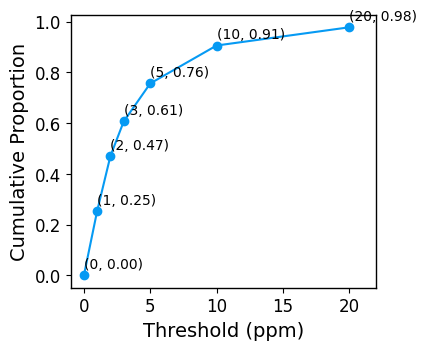

R2 = 0.96
RMSE = 6.44
MAE = 3.9775556375752115


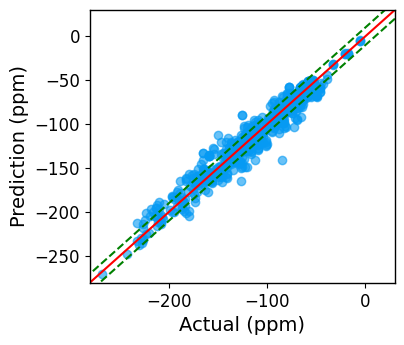

In [42]:
results_table = common.get_results_table(best_model, X_train_scaled, y_train)
common.plot_prediction_performance(results_table)

common.show_results_scatter(results_table)

## 7.4 Spatially Neighboring atoms = 10 <a class="anchor" id="7.4"></a>

In [43]:
train_fluorinated_compounds_w_Desc = atomic_features_3D.Combine_descriptors(
    train_fluorinated_compounds, neighbor_num=10, with_additional_info=True
)

print(
    f"Shape of the train_fluorinated_compounds_w_Desc: {train_fluorinated_compounds_w_Desc.shape}"
)

train_fluorinated_compounds_w_Desc.rename_axis(
    "atomCode_fluorinated_compoundsCode", inplace=True
)

file_path = os.path.join("..", "artifacts", "temp", f"train_dataset_3D_neighbors10.csv")
train_fluorinated_compounds_w_Desc.to_csv(file_path, encoding="utf-8")
train_fluorinated_compounds_w_Desc.head(3)

Shape of the train_fluorinated_compounds_w_Desc: (2351, 222)


,NMR_Peaks,SMILES_self,AtomDegreeDescriptor-aNeg_self,AtomHybridizationDescriptor-aHyb_self,AtomHybridizationVSEPRDescriptor-hybr_self,AtomValenceDescriptor-val_self,BondsToAtomDescriptor-bondsToAtom_self,CovalentRadiusDescriptor-covalentRadius_self,DistanceToAtomDescriptor-distanceToAtom_self,EffectiveAtomPolarizabilityDescriptor-effAtomPol_self,IPAtomicHOSEDescriptor-ipAtomicHOSE_self,InductiveAtomicHardnessDescriptor-indAtomHardnesss_self,InductiveAtomicSoftnessDescriptor-indAtomSoftness_self,PartialPiChargeDescriptor-pepe_self,PartialSigmaChargeDescriptor-partialSigmaCharge_self,PartialTChargeMMFF94Descriptor-partialTCMMFF94_self,PartialTChargePEOEDescriptor-pepeT_self,PeriodicTablePositionDescriptor-periodicTablePosition_self,PiElectronegativityDescriptor-elecPiA_self,level_0_neighbor1,index_neighbor1,SMILES_neighbor1,AtomDegreeDescriptor-aNeg_neighbor1,AtomHybridizationDescriptor-aHyb_neighbor1,AtomHybridizationVSEPRDescriptor-hybr_neighbor1,AtomValenceDescriptor-val_neighbor1,BondsToAtomDescriptor-bondsToAtom_neighbor1,CovalentRadiusDescriptor-covalentRadius_neighbor1,DistanceToAtomDescriptor-distanceToAtom_neighbor1,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor1,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor1,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor1,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor1,PartialPiChargeDescriptor-pepe_neighbor1,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor1,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor1,PartialTChargePEOEDescriptor-pepeT_neighbor1,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor1,PiElectronegativityDescriptor-elecPiA_neighbor1,level_0_neighbor2,index_neighbor2,SMILES_neighbor2,AtomDegreeDescriptor-aNeg_neighbor2,AtomHybridizationDescriptor-aHyb_neighbor2,AtomHybridizationVSEPRDescriptor-hybr_neighbor2,AtomValenceDescriptor-val_neighbor2,BondsToAtomDescriptor-bondsToAtom_neighbor2,CovalentRadiusDescriptor-covalentRadius_neighbor2,DistanceToAtomDescriptor-distanceToAtom_neighbor2,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor2,...,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor8,PartialPiChargeDescriptor-pepe_neighbor8,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor8,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor8,PartialTChargePEOEDescriptor-pepeT_neighbor8,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor8,PiElectronegativityDescriptor-elecPiA_neighbor8,level_0_neighbor9,index_neighbor9,SMILES_neighbor9,AtomDegreeDescriptor-aNeg_neighbor9,AtomHybridizationDescriptor-aHyb_neighbor9,AtomHybridizationVSEPRDescriptor-hybr_neighbor9,AtomValenceDescriptor-val_neighbor9,BondsToAtomDescriptor-bondsToAtom_neighbor9,CovalentRadiusDescriptor-covalentRadius_neighbor9,DistanceToAtomDescriptor-distanceToAtom_neighbor9,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor9,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor9,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor9,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor9,PartialPiChargeDescriptor-pepe_neighbor9,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor9,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor9,PartialTChargePEOEDescriptor-pepeT_neighbor9,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor9,PiElectronegativityDescriptor-elecPiA_neighbor9,level_0_neighbor10,index_neighbor10,SMILES_neighbor10,AtomDegreeDescriptor-aNeg_neighbor10,AtomHybridizationDescriptor-aHyb_neighbor10,AtomHybridizationVSEPRDescriptor-hybr_neighbor10,AtomValenceDescriptor-val_neighbor10,BondsToAtomDescriptor-bondsToAtom_neighbor10,CovalentRadiusDescriptor-covalentRadius_neighbor10,DistanceToAtomDescriptor-distanceToAtom_neighbor10,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor10,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor10,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor10,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor10,PartialPiChargeDescriptor-pepe

In [44]:
train_dataset = train_fluorinated_compounds_w_Desc.copy()

dataset = common.drop_constant_col(train_dataset)
print(
    f"Shape of the training dataset after dropping out columns with constant values: {dataset.shape}"
)

dataset_dropNaN = common.drop_high_ratio_NaN_cols(dataset)
print(
    f"\nShape of the training dataset after dropping out columns with more than 80% values being NaN: {dataset_dropNaN.shape}"
)

# drop rows with NaN values in the 'NMR_Peaks' column
dataset_dropNaN = dataset_dropNaN.dropna(subset=["NMR_Peaks"])
print("\n")
print(f"-----Shape of the dataset after drop rows with NaN NMR peak values------")
print(dataset_dropNaN.shape)

# Convert all columns in df to numeric where possible, keeping non-numeric values unchanged
dataset_dropNaN = dataset_dropNaN.apply(pd.to_numeric, errors="ignore")

print(common.count_non_numeric_values(dataset_dropNaN))
# Drop categorical columns

dataset_dropCat = common.drop_categorical_columns(dataset_dropNaN)

dataset_dropCat, imputer = common.fill_NaN(dataset_dropCat)

file_path = os.path.join("..", "artifacts", "models", f"imputer_neighbor10_RidgeCV.pkl")
with open(file_path, "wb") as file:
    pickle.dump(imputer, file)

columns = dataset_dropCat.columns.tolist()
file_path = os.path.join(
    "..", "artifacts", "models", f"column_names_neighbor10_RidgeCV.pkl"
)
with open(file_path, "wb") as f:
    pickle.dump(columns, f)

print(f"\n-----Shape of the dataset after pre-processing------")
print(dataset_dropCat.shape)

Shape of the training dataset after dropping out columns with constant values: (2351, 195)

Shape of the training dataset after dropping out columns with more than 80% values being NaN: (2351, 195)


-----Shape of the dataset after drop rows with NaN NMR peak values------
(2281, 195)
Columns with Non-Numeric Values:
SMILES_neighbor2        2281
SMILES_neighbor3        2280
SMILES_neighbor4        2279
SMILES_neighbor5        2255
SMILES_neighbor6        2199
                        ... 
SMILES_neighbor9        2020
SMILES_neighbor10       1920
SMILES                  2281
Compound name           2281
Solvent_used_for_NMR    2281
Length: 12, dtype: int64
None


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_1625/1126129156.py:20: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  dataset_dropNaN = dataset_dropNaN.apply(pd.to_numeric, errors="ignore")



-----Shape of the dataset after pre-processing------
(2281, 183)


In [45]:
y_train = dataset_dropCat["NMR_Peaks"]
X_train = dataset_dropCat.drop(["NMR_Peaks"], axis=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

file_path = os.path.join(
    "..", "artifacts", "models", f"scaler_3d_neighbors10_RidgeCV.pkl"
)
with open(file_path, "wb") as file:
    pickle.dump(scaler, file)

X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = X_train.columns
X_train_scaled.index = X_train.index


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


scoring = {
    "mae": "neg_mean_absolute_error",
    "rmse": make_scorer(rmse),  # Custom RMSE scorer
    "r2": "r2",
}

param_grid = {"alpha": [10, 50, 80, 90, 100, 150, 200]}

# Create the Ridge model
ridge = Ridge(fit_intercept=True)

# Initialize GridSearchCV with multiple scoring metrics
grid_search = GridSearchCV(
    estimator=ridge, param_grid=param_grid, cv=5, scoring=scoring, refit="mae"
)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best alpha and results for each metric
best_alpha = grid_search.best_params_["alpha"]
best_scores = grid_search.cv_results_


# Output the best alpha and performance on chosen metric
print(f"Best Alpha: {best_alpha}")

# Print out scoring metrics for the best model
print(f'MAE Score: {np.mean(-best_scores["mean_test_mae"]):.2f}')
print(f"Root Mean Squared Error (RMSE): {np.mean(best_scores['mean_test_rmse']):.2f}")
print(f'R^2 Score: {np.mean(best_scores["mean_test_r2"]):.2f}')

Best Alpha: 10
MAE Score: 5.62
Root Mean Squared Error (RMSE): 9.98
R^2 Score: 0.90


In [46]:
param_grid = {"alpha": [1, 3, 5, 6, 7, 8, 9, 11, 12, 15]}

# Initialize GridSearchCV with multiple scoring metrics
grid_search = GridSearchCV(
    estimator=ridge, param_grid=param_grid, cv=5, scoring=scoring, refit="mae"
)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best alpha and results for each metric
best_alpha = grid_search.best_params_["alpha"]
best_scores = grid_search.cv_results_


# Output the best alpha and performance on chosen metric
print(f"Best Alpha: {best_alpha}")

# Print out scoring metrics for the best model
print(f'MAE Score: {np.mean(-best_scores["mean_test_mae"]):.2f}')
print(f"Root Mean Squared Error (RMSE): {np.mean(best_scores['mean_test_rmse']):.2f}")
print(f'R^2 Score: {np.mean(best_scores["mean_test_r2"]):.2f}')

Best Alpha: 3
MAE Score: 5.20
Root Mean Squared Error (RMSE): 10.70
R^2 Score: 0.87


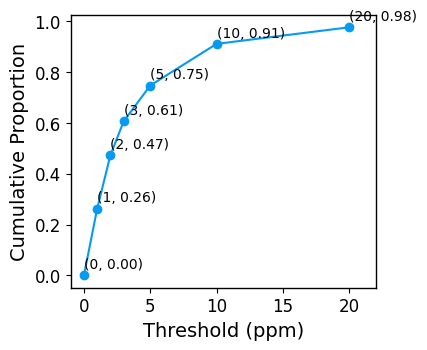

R2 = 0.96
RMSE = 6.33
MAE = 3.928863639228836


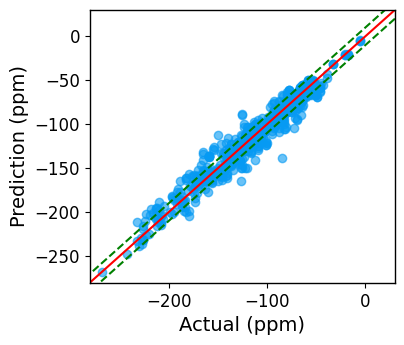

In [47]:
best_model = grid_search.best_estimator_
file_path = os.path.join("..", "artifacts", "models", f"RidgeCV_model_neighbor10.pkl")
with open(file_path, "wb") as file:
    pickle.dump(best_model, file)

results_table = common.get_results_table(best_model, X_train_scaled, y_train)
common.plot_prediction_performance(results_table)

common.show_results_scatter(results_table)

## 7.5 Compare Model Performance using the Validation dataset <a class="anchor" id="7.5"></a>

In [48]:
# vali_fluorinated_compounds_w_Desc = Combine_descriptors(vali_fluorinated_compounds, neighbor_num = 7, with_additional_info = True)

# print(f'Shape of the vali_fluorinated_compounds_w_Desc: {vali_fluorinated_compounds_w_Desc.shape}')

# vali_fluorinated_compounds_w_Desc.rename_axis('atomCode_fluorinated_compoundsCode', inplace = True)

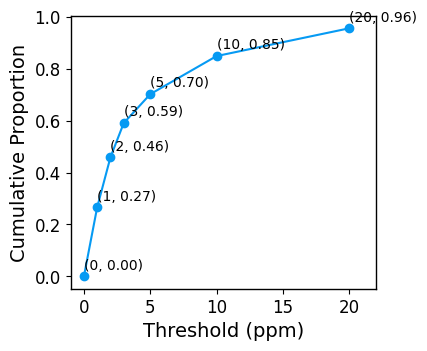

R2 = 0.89
RMSE = 9.85
MAE = 5.088501804243989


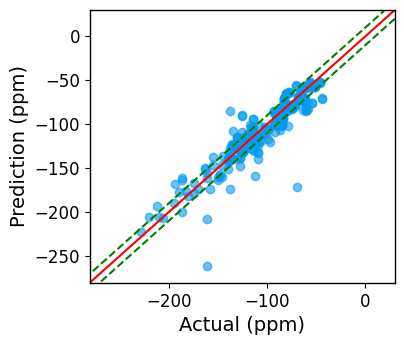

,actual,prediction,diff
4_From_Review_316,-66.00,-69.022587,3.022587
5_From_Review_316,-66.00,-70.317284,4.317284
6_From_Review_316,-66.00,-68.750647,2.750647
7_SO3H_25,-115.13,-108.372551,6.757449
8_SO3H_25,-115.13,-113.367501,1.762499
...,...,...,...
0_Cl_4,-79.65,-76.566614,3.083386
2_Cl_4,-79.65,-79.661731,0.011731
3_Cl_4,-79.65,-79.759801,0.109801
5_Cl_4,-120.25,-120.005844,0.244156


In [49]:
base_file_path = os.path.join("..", "artifacts", "models")
common.testRidgeCVPerformance(
    dataset=vali_fluorinated_compounds,
    neighbor_num=3,
    RidgeCVmodel_path=os.path.join(base_file_path, "RidgeCV_model_neighbor3.pkl"),
    scaler_path=os.path.join(base_file_path, "scaler_3d_neighbor3_RidgeCV.pkl"),
    imputer_path=os.path.join(base_file_path, "imputer_neighbor3_RidgeCV.pkl"),
    columns_path=os.path.join(base_file_path, "column_names_neighbor3_RidgeCV.pkl"),
)

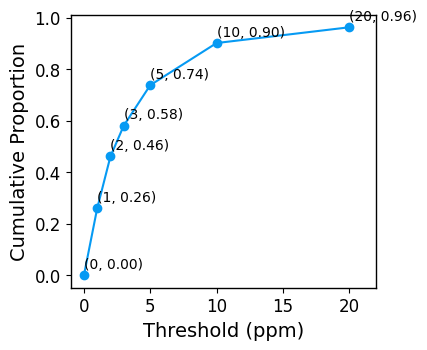

R2 = 0.90
RMSE = 9.04
MAE = 4.545745173748309


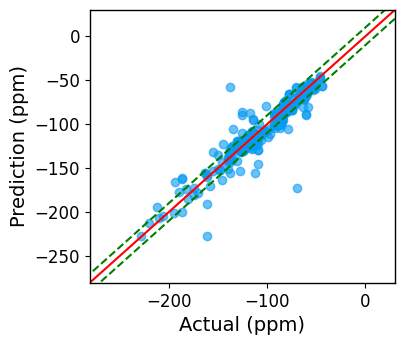

In [50]:
base_file_path = os.path.join("..", "artifacts", "models")
# neighbors 5, validation dataset
restuls_table = common.testRidgeCVPerformance(
    dataset=vali_fluorinated_compounds,
    neighbor_num=5,
    RidgeCVmodel_path=os.path.join(base_file_path, "RidgeCV_model_neighbor5.pkl"),
    scaler_path=os.path.join(base_file_path, "scaler_3d_neighbors5_RidgeCV.pkl"),
    imputer_path=os.path.join(base_file_path, "imputer_neighbor5_RidgeCV.pkl"),
    columns_path=os.path.join(base_file_path, "column_names_neighbor5_RidgeCV.pkl"),
)

In [51]:
file_path = os.path.join("..", "artifacts", "results")
restuls_table.to_csv(
    os.path.join(file_path, "RidgeCV_3DFeatureSet_neighbor5_valiDataset.csv")
)

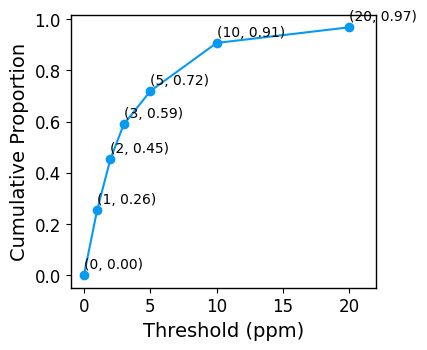

R2 = 0.90
RMSE = 9.15
MAE = 4.572749000881624


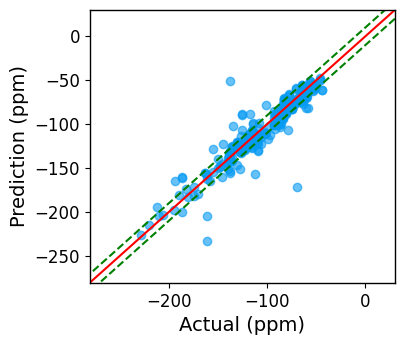

,actual,prediction,diff
4_From_Review_316,-66.00,-73.598098,7.598098
5_From_Review_316,-66.00,-74.698789,8.698789
6_From_Review_316,-66.00,-73.027543,7.027543
7_SO3H_25,-115.13,-107.685081,7.444919
8_SO3H_25,-115.13,-109.399482,5.730518
...,...,...,...
0_Cl_4,-79.65,-80.580843,0.930843
2_Cl_4,-79.65,-84.421694,4.771694
3_Cl_4,-79.65,-82.847138,3.197138
5_Cl_4,-120.25,-118.147141,2.102859


In [52]:
base_file_path = os.path.join("..", "artifacts", "models")
common.testRidgeCVPerformance(
    dataset=vali_fluorinated_compounds,
    neighbor_num=7,
    RidgeCVmodel_path=os.path.join(base_file_path, "RidgeCV_model_neighbor7.pkl"),
    scaler_path=os.path.join(base_file_path, "scaler_3d_neighbors7_RidgeCV.pkl"),
    imputer_path=os.path.join(base_file_path, "imputer_neighbor7_RidgeCV.pkl"),
    columns_path=os.path.join(base_file_path, "column_names_neighbor7_RidgeCV.pkl"),
)

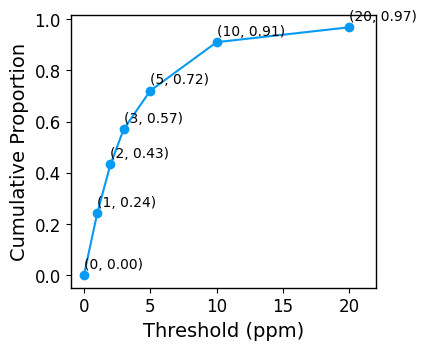

R2 = 0.90
RMSE = 9.12
MAE = 4.688763410481307


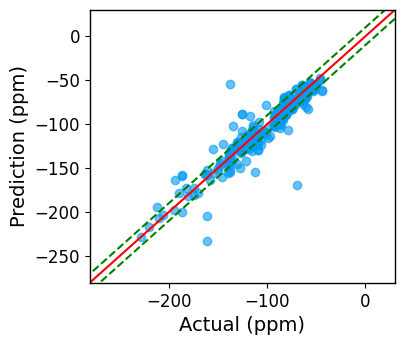

,actual,prediction,diff
4_From_Review_316,-66.00,-73.075653,7.075653
5_From_Review_316,-66.00,-74.042735,8.042735
6_From_Review_316,-66.00,-72.847088,6.847088
7_SO3H_25,-115.13,-107.621298,7.508702
8_SO3H_25,-115.13,-108.773926,6.356074
...,...,...,...
0_Cl_4,-79.65,-80.294758,0.644758
2_Cl_4,-79.65,-84.572474,4.922474
3_Cl_4,-79.65,-83.312059,3.662059
5_Cl_4,-120.25,-116.038137,4.211863


In [53]:
base_file_path = os.path.join("..", "artifacts", "models")
common.testRidgeCVPerformance(
    dataset=vali_fluorinated_compounds,
    neighbor_num=10,
    RidgeCVmodel_path=os.path.join(base_file_path, "RidgeCV_model_neighbor10.pkl"),
    scaler_path=os.path.join(base_file_path, "scaler_3d_neighbors10_RidgeCV.pkl"),
    imputer_path=os.path.join(base_file_path, "imputer_neighbor10_RidgeCV.pkl"),
    columns_path=os.path.join(base_file_path, "column_names_neighbor10_RidgeCV.pkl"),
)

Use descriptors from 5 atoms near the target F atom seems to have the best modeling performance.

## 7.6 Feature Importance<a class="anchor" id="7.6"></a>
**Coorelation analysis**

**Pearson correlation coefficient:** Correlation coefficients whose magnitude are between `0.9 and 1.0` indicate variables which can be considered `very highly correlated`. Correlation coefficients whose magnitude are between `0.7 and 0.9` indicate variables which can be considered `highly correlated`. Correlation coefficients whose magnitude are between `0.5 and 0.7` indicate variables which can be considered `moderately correlated`. Correlation coefficients whose magnitude are between `0.3 and 0.5` indicate variables which have a `low correlation`. Correlation coefficients whose magnitude are `less than 0.3` have `little if any (linear) correlation`. 

In [54]:
file_path = os.path.join("..", "artifacts", "temp")
dataset = pd.read_csv(
    os.path.join(file_path, "train_dataset_3D_neighbors5.csv"), index_col=0
)

# convert values to numeric values when possible
dataset = dataset.apply(common.convert_to_numeric)

dataset = common.drop_constant_col(dataset)

dataset_dropNaN = common.drop_high_ratio_NaN_cols(dataset)

# drop rows with NaN values in the 'NMR_Peaks' column
dataset_dropNaN = dataset_dropNaN.dropna(subset=["NMR_Peaks"])


# Drop categorical columns
dataset_dropCat = common.drop_categorical_columns(dataset_dropNaN)

dataset_dropCat, imputer = common.fill_NaN(dataset_dropCat)

dataset_dropCat.shape

(2281, 98)

In [55]:
correlation_matrix = dataset.corr()

# Set a threshold for high correlation
threshold = 0.95

columns_to_drop = set()

# Find pairs of highly correlated columns
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            columns_to_drop.add(colname)  # Add one column of the pair to the set

# Drop one of each highly correlated pair
dataset_reduced = dataset.drop(columns=columns_to_drop)
dataset_reduced.shape

(2351, 76)

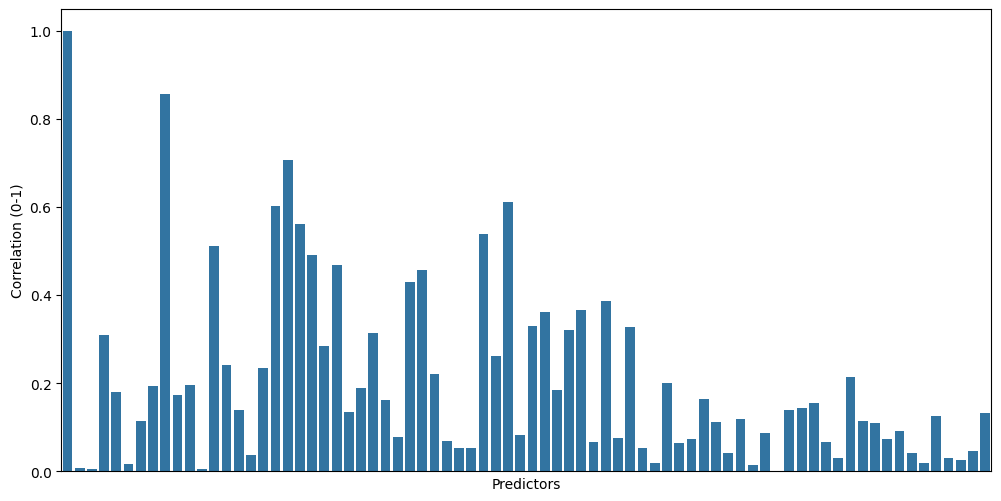

In [56]:
# Correlation between variables
data = dataset_reduced
data["NMR_Peaks"] = pd.to_numeric(data["NMR_Peaks"], errors="coerce")
corr = data.corr(numeric_only=True)["NMR_Peaks"].abs()

f, ax = plt.subplots(figsize=(12, 6))

sns.barplot(y=corr, x=corr.index, ax=ax)
ax.set_xlabel("Predictors")
ax.set_xticklabels("")
ax.set_xticks([])
ax.set_ylabel("Correlation (0-1)")
plt.show()

In [57]:
print(corr[corr > 0.8])
print(corr[corr > 0.8].index.values)

NMR_Peaks                                               1.000000
PartialSigmaChargeDescriptor-partialSigmaCharge_self    0.857519
Name: NMR_Peaks, dtype: float64
['NMR_Peaks' 'PartialSigmaChargeDescriptor-partialSigmaCharge_self']


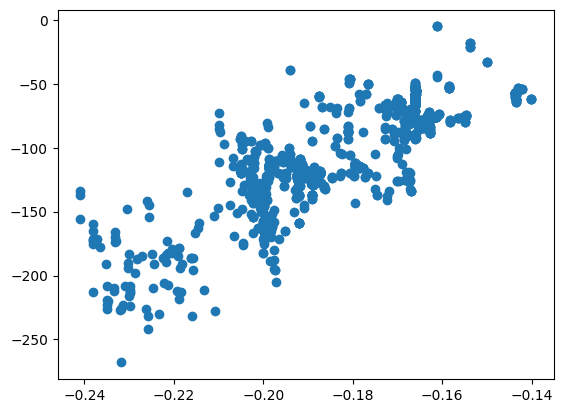

In [58]:
x = data["PartialSigmaChargeDescriptor-partialSigmaCharge_self"]
y = data["NMR_Peaks"]
plt.scatter(x, y)

***Results***
"AtomHybridizationDescriptor-aHyb" and "AtomHybridizationVSEPRDescriptor-hybr" (coef. = 1.0)
"AtomValenceDescriptor-val" correlated with "CovalentRadiusDescriptor-covalentRadius" (coef. = -1.0) and "RDFProtonDescriptor_G3R-g3r_4" (coef. = -1.0)
"PartialSigmaChargeDescriptor-partialSigmaCharge" correlated with "PartialTChargePEOEDescriptor-pepeT" (coef. = 1.0) and "ProtonTotalPartialChargeDescriptor-protonTotalPartialCharge1" (coef. = 1.0)

***Delete*** "AtomHybridizationVSEPRDescriptor-hybr",  "CovalentRadiusDescriptor-covalentRadius", "RDFProtonDescriptor_G3R-g3r_4", "PartialTChargePEOEDescriptor-pepeT", "ProtonTotalPartialChargeDescriptor-protonTotalPartialCharge1"

# VIII. Ridge Model with 2D feature set<a class="anchor" id="8"></a>

In [59]:
data_path = os.path.join("..", "dataset", "Raw_PFAS 19F NMR spectra data.csv")
all_fluorinated_compounds = pd.read_csv(data_path, index_col=0)

# Train, validation, test dataset split
train_fluorinated_compounds, test_fluorinated_compounds = train_test_split(
    all_fluorinated_compounds, test_size=0.15, random_state=RANDOM_STATE, shuffle=True
)
train_fluorinated_compounds, vali_fluorinated_compounds = train_test_split(
    train_fluorinated_compounds, test_size=0.2, random_state=RANDOM_STATE, shuffle=True
)
print(
    f"Number of fluorinated_compounds in the train dataset: {train_fluorinated_compounds.shape[0]}"
)
print(
    f"Number of fluorinated_compounds in the validation dataset: {vali_fluorinated_compounds.shape[0]}"
)
print(
    f"Number of fluorinated_compounds in the test dataset: {test_fluorinated_compounds.shape[0]}"
)

# Transform the column names of the DataFrame to integers where possible and keep them as strings otherwise
train_fluorinated_compounds.columns = [
    common.convert_column_name(name) for name in train_fluorinated_compounds.columns
]
vali_fluorinated_compounds.columns = [
    common.convert_column_name(name) for name in vali_fluorinated_compounds.columns
]
test_fluorinated_compounds.columns = [
    common.convert_column_name(name) for name in test_fluorinated_compounds.columns
]

Number of fluorinated_compounds in the train dataset: 439
Number of fluorinated_compounds in the validation dataset: 110
Number of fluorinated_compounds in the test dataset: 98


## 8.1 Neighboring Spheres = 2 <a class="anchor" id="8.1"></a>

In [60]:
get_2d_descriptors = atomic_features_2D.getAtomicDescriptorsFrom2DNeighbors()
train_content = get_2d_descriptors.getDescriptorsFromDataset(
    train_fluorinated_compounds, 2
)
train_content

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,NMR_Peaks
4_ether_12,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,2.0,0.0,3.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,-119.9
5_ether_12,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,2.0,0.0,3.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,-119.9
7_ether_12,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,-129.4
8_ether_12,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,-129.4
10_ether_12,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,15.999,3.0,0.0,2.0,2.0,2.0,0.0,-87.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26_acrylates_8,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,-72.02
27_acrylates_8,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,-72.02
29_acrylates_8,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,-72.02
30_acrylates_8,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,-72.02


In [61]:
train_dataset = train_content.copy()

dataset = common.drop_constant_col(train_dataset)
print(
    f"Shape of the training dataset after dropping out columns with constant values: {dataset.shape}"
)

dataset_dropNaN = common.drop_high_ratio_NaN_cols(dataset)
print(
    f"\nShape of the training dataset after dropping out columns with more than 80% values being NaN: {dataset_dropNaN.shape}"
)

# drop rows with NaN values in the 'NMR_Peaks' column
dataset_dropNaN = dataset_dropNaN.dropna(subset=["NMR_Peaks"])
print("\n")
print(f"-----Shape of the dataset after drop rows with NaN NMR peak values------")
print(dataset_dropNaN.shape)

# Convert all columns in df to numeric where possible, keeping non-numeric values unchanged
dataset_dropNaN = dataset_dropNaN.apply(pd.to_numeric, errors="ignore")

print(common.count_non_numeric_values(dataset_dropNaN))
# Drop categorical columns

dataset_dropCat = common.drop_categorical_columns(dataset_dropNaN)

# Conver column names to 'string'
dataset_dropCat.columns = dataset_dropCat.columns.astype(str)

dataset_dropCat, imputer = common.fill_NaN(dataset_dropCat)

file_path = os.path.join("..", "artifacts", "models", "imputer_2d_sphere2_Ridge.pkl")
with open(file_path, "wb") as file:
    pickle.dump(imputer, file)

columns = dataset_dropCat.columns.tolist()
file_path = os.path.join(
    "..", "artifacts", "models", "column_names_2d_sphere2_Ridge.pkl"
)
with open(file_path, "wb") as f:
    pickle.dump(columns, f)

print(f"\n-----Shape of the dataset after pre-processing------")
print(dataset_dropCat.shape)

Shape of the training dataset after dropping out columns with constant values: (2351, 27)

Shape of the training dataset after dropping out columns with more than 80% values being NaN: (2351, 27)


-----Shape of the dataset after drop rows with NaN NMR peak values------
(2276, 27)
Columns with Non-Numeric Values:
Series([], dtype: int64)
None

-----Shape of the dataset after pre-processing------
(2276, 27)


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_1625/1080563105.py:20: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  dataset_dropNaN = dataset_dropNaN.apply(pd.to_numeric, errors="ignore")


In [62]:
dataset = dataset_dropCat.copy()
y_train = dataset["NMR_Peaks"]
X_train = dataset.drop(["NMR_Peaks"], axis=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

file_path = os.path.join("..", "artifacts", "models", f"scaler_2d_sphere2_Ridge.pkl")
with open(file_path, "wb") as file:
    pickle.dump(scaler, file)

X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = X_train.columns
X_train_scaled.index = X_train.index

# Define a custom RMSE scoring function


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


scoring = {
    "mae": "neg_mean_absolute_error",
    "rmse": make_scorer(rmse),  # Custom RMSE scorer
    "r2": "r2",
}


param_grid = {"alpha": [10, 50, 80, 90, 100, 150, 200]}

# Create the Ridge model
ridge = Ridge(fit_intercept=True)

# Initialize GridSearchCV with multiple scoring metrics
grid_search = GridSearchCV(
    estimator=ridge, param_grid=param_grid, cv=5, scoring=scoring, refit="mae"
)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best alpha and results for each metric
best_alpha = grid_search.best_params_["alpha"]
best_scores = grid_search.cv_results_


# Output the best alpha and performance on chosen metric
print(f"Best Alpha: {best_alpha}")

# Print out scoring metrics for the best model
print(f'MAE Score: {np.mean(-best_scores["mean_test_mae"]):.2f}')
print(f"Root Mean Squared Error (RMSE): {np.mean(best_scores['mean_test_rmse']):.2f}")
print(f'R^2 Score: {np.mean(best_scores["mean_test_r2"]):.2f}')

Best Alpha: 50
MAE Score: 5.28
Root Mean Squared Error (RMSE): 8.75
R^2 Score: 0.93


In [63]:
param_grid = {"alpha": [20, 30, 35, 40, 45, 55, 60, 70]}

grid_search = GridSearchCV(
    estimator=ridge, param_grid=param_grid, cv=5, scoring=scoring, refit="mae"
)
grid_search.fit(X_train_scaled, y_train)

# Output the best alpha and performance on chosen metric
print(f"Best Alpha: {best_alpha}")

# Print out scoring metrics for the best model
print(f'MAE Score: {np.mean(-best_scores["mean_test_mae"]):.2f}')
print(f"Root Mean Squared Error (RMSE): {np.mean(best_scores['mean_test_rmse']):.2f}")
print(f'R^2 Score: {np.mean(best_scores["mean_test_r2"]):.2f}')

Best Alpha: 50
MAE Score: 5.28
Root Mean Squared Error (RMSE): 8.75
R^2 Score: 0.93


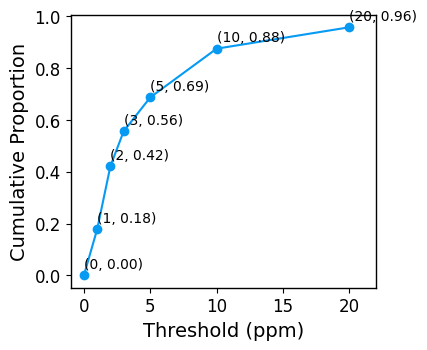

R2 = 0.94
RMSE = 8.08
MAE = 5.027477328449095


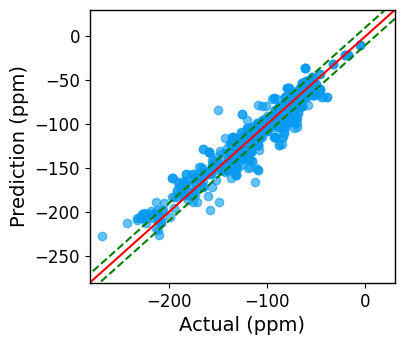

In [64]:
best_model = grid_search.best_estimator_

file_path = os.path.join("..", "artifacts", "models", f"RidgeCV_model_2d_sphere2.pkl")
with open(file_path, "wb") as file:
    pickle.dump(best_model, file)

results_table = common.get_results_table(best_model, X_train_scaled, y_train)
common.plot_prediction_performance(results_table)

common.show_results_scatter(results_table)

## 8.2 Neighboring Spheres = 3 <a class="anchor" id="8.2"></a>

In [65]:
get_2d_descriptors = atomic_features_2D.getAtomicDescriptorsFrom2DNeighbors()
train_dataset = get_2d_descriptors.getDescriptorsFromDataset(
    train_fluorinated_compounds, 3
)

dataset = common.drop_constant_col(train_dataset)
print(
    f"Shape of the training dataset after dropping out columns with constant values: {dataset.shape}"
)

dataset_dropNaN = common.drop_high_ratio_NaN_cols(dataset)
print(
    f"\nShape of the training dataset after dropping out columns with more than 80% values being NaN: {dataset_dropNaN.shape}"
)

# drop rows with NaN values in the 'NMR_Peaks' column
dataset_dropNaN = dataset_dropNaN.dropna(subset=["NMR_Peaks"])
print("\n")
print(f"-----Shape of the dataset after drop rows with NaN NMR peak values------")
print(dataset_dropNaN.shape)

# Convert all columns in df to numeric where possible, keeping non-numeric values unchanged
dataset_dropNaN = dataset_dropNaN.apply(pd.to_numeric, errors="ignore")

print(common.count_non_numeric_values(dataset_dropNaN))
# Drop categorical columns

dataset_dropCat = common.drop_categorical_columns(dataset_dropNaN)

# Conver column names to 'string'
dataset_dropCat.columns = dataset_dropCat.columns.astype(str)

dataset_dropCat, imputer = common.fill_NaN(dataset_dropCat)

file_path = os.path.join("..", "artifacts", "models", "imputer_2d_sphere3_Ridge.pkl")
with open(file_path, "wb") as file:
    pickle.dump(imputer, file)

columns = dataset_dropCat.columns.tolist()
file_path = os.path.join(
    "..", "artifacts", "models", "column_names_2d_sphere3_Ridge.pkl"
)
with open(file_path, "wb") as f:
    pickle.dump(columns, f)

print(f"\n-----Shape of the dataset after pre-processing------")
print(dataset_dropCat.shape)


dataset = dataset_dropCat.copy()
y_train = dataset["NMR_Peaks"]
X_train = dataset.drop(["NMR_Peaks"], axis=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

file_path = os.path.join("..", "artifacts", "models", f"scaler_2d_sphere3_Ridge.pkl")
with open(file_path, "wb") as file:
    pickle.dump(scaler, file)

X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = X_train.columns
X_train_scaled.index = X_train.index

param_grid = {"alpha": [10, 50, 80, 90, 100, 150, 200]}

# Create the Ridge model
ridge = Ridge(fit_intercept=True)

# Initialize GridSearchCV with multiple scoring metrics
grid_search = GridSearchCV(
    estimator=ridge, param_grid=param_grid, cv=5, scoring=scoring, refit="mae"
)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best alpha and results for each metric
best_alpha = grid_search.best_params_["alpha"]
best_scores = grid_search.cv_results_


# Output the best alpha and performance on chosen metric
print(f"Best Alpha: {best_alpha}")

# Print out scoring metrics for the best model
print(f'MAE Score: {np.mean(-best_scores["mean_test_mae"]):.2f}')
print(f"Root Mean Squared Error (RMSE): {np.mean(best_scores['mean_test_rmse']):.2f}")
print(f'R^2 Score: {np.mean(best_scores["mean_test_r2"]):.2f}')

Shape of the training dataset after dropping out columns with constant values: (2351, 77)

Shape of the training dataset after dropping out columns with more than 80% values being NaN: (2351, 69)


-----Shape of the dataset after drop rows with NaN NMR peak values------
(2276, 69)
Columns with Non-Numeric Values:
Series([], dtype: int64)
None


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_1625/59803230.py:23: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  dataset_dropNaN = dataset_dropNaN.apply(pd.to_numeric, errors="ignore")



-----Shape of the dataset after pre-processing------
(2276, 69)
Best Alpha: 10
MAE Score: 4.66
Root Mean Squared Error (RMSE): 8.27
R^2 Score: 0.94


In [66]:
param_grid = {"alpha": [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15]}

# Initialize GridSearchCV with multiple scoring metrics
grid_search = GridSearchCV(
    estimator=ridge, param_grid=param_grid, cv=5, scoring=scoring, refit="mae"
)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best alpha and results for each metric
best_alpha = grid_search.best_params_["alpha"]
best_scores = grid_search.cv_results_


# Output the best alpha and performance on chosen metric
print(f"Best Alpha: {best_alpha}")

# Print out scoring metrics for the best model
print(f'MAE Score: {np.mean(-best_scores["mean_test_mae"]):.2f}')
print(f"Root Mean Squared Error (RMSE): {np.mean(best_scores['mean_test_rmse']):.2f}")
print(f'R^2 Score: {np.mean(best_scores["mean_test_r2"]):.2f}')

Best Alpha: 11
MAE Score: 4.54
Root Mean Squared Error (RMSE): 8.22
R^2 Score: 0.94


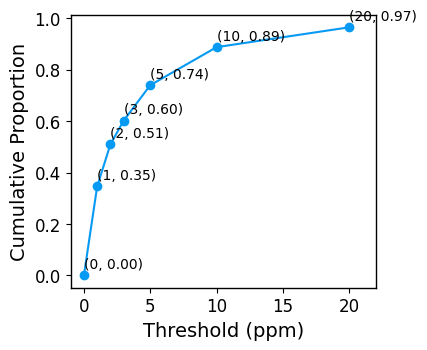

R2 = 0.95
RMSE = 7.13
MAE = 4.117786144407508


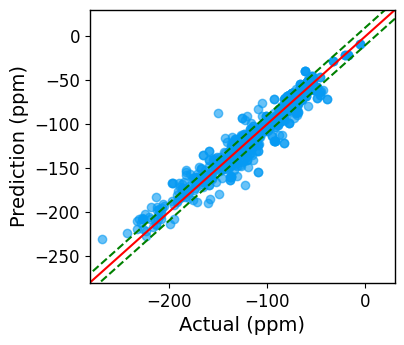

In [67]:
best_model = grid_search.best_estimator_

file_path = os.path.join("..", "artifacts", "models", f"RidgeCV_model_2d_sphere3.pkl")
with open(file_path, "wb") as file:
    pickle.dump(best_model, file)

results_table = common.get_results_table(best_model, X_train_scaled, y_train)
common.plot_prediction_performance(results_table)

common.show_results_scatter(results_table)

## 8.3 Neighboring Spheres = 4 <a class="anchor" id="8.3"></a>

In [68]:
get_2d_descriptors = atomic_features_2D.getAtomicDescriptorsFrom2DNeighbors()
train_dataset = get_2d_descriptors.getDescriptorsFromDataset(
    train_fluorinated_compounds, 4
)

dataset = common.drop_constant_col(train_dataset)
print(
    f"Shape of the training dataset after dropping out columns with constant values: {dataset.shape}"
)

dataset_dropNaN = common.drop_high_ratio_NaN_cols(dataset)
print(
    f"\nShape of the training dataset after dropping out columns with more than 80% values being NaN: {dataset_dropNaN.shape}"
)

# drop rows with NaN values in the 'NMR_Peaks' column
dataset_dropNaN = dataset_dropNaN.dropna(subset=["NMR_Peaks"])
print("\n")
print(f"-----Shape of the dataset after drop rows with NaN NMR peak values------")
print(dataset_dropNaN.shape)

# Convert all columns in df to numeric where possible, keeping non-numeric values unchanged
dataset_dropNaN = dataset_dropNaN.apply(pd.to_numeric, errors="ignore")

print(common.count_non_numeric_values(dataset_dropNaN))
# Drop categorical columns

dataset_dropCat = common.drop_categorical_columns(dataset_dropNaN)

# Conver column names to 'string'
dataset_dropCat.columns = dataset_dropCat.columns.astype(str)

dataset_dropCat, imputer = common.fill_NaN(dataset_dropCat)

file_path = os.path.join("..", "artifacts", "models", "imputer_2d_sphere4_Ridge.pkl")
with open(file_path, "wb") as file:
    pickle.dump(imputer, file)

columns = dataset_dropCat.columns.tolist()
file_path = os.path.join(
    "..", "artifacts", "models", "column_names_2d_sphere4_Ridge.pkl"
)
with open(file_path, "wb") as f:
    pickle.dump(columns, f)

print(f"\n-----Shape of the dataset after pre-processing------")
print(dataset_dropCat.shape)


dataset = dataset_dropCat.copy()
y_train = dataset["NMR_Peaks"]
X_train = dataset.drop(["NMR_Peaks"], axis=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

file_path = os.path.join("..", "artifacts", "models", f"scaler_2d_sphere4_Ridge.pkl")
with open(file_path, "wb") as file:
    pickle.dump(scaler, file)

X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = X_train.columns
X_train_scaled.index = X_train.index

param_grid = {"alpha": [10, 50, 80, 90, 100, 150, 200]}

# Create the Ridge model
ridge = Ridge(fit_intercept=True)

# Initialize GridSearchCV with multiple scoring metrics
grid_search = GridSearchCV(
    estimator=ridge, param_grid=param_grid, cv=5, scoring=scoring, refit="mae"
)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best alpha and results for each metric
best_alpha = grid_search.best_params_["alpha"]
best_scores = grid_search.cv_results_


# Output the best alpha and performance on chosen metric
print(f"Best Alpha: {best_alpha}")

# Print out scoring metrics for the best model
print(f'MAE Score: {np.mean(-best_scores["mean_test_mae"]):.2f}')
print(f"Root Mean Squared Error (RMSE): {np.mean(best_scores['mean_test_rmse']):.2f}")
print(f'R^2 Score: {np.mean(best_scores["mean_test_r2"]):.2f}')

Shape of the training dataset after dropping out columns with constant values: (2351, 130)

Shape of the training dataset after dropping out columns with more than 80% values being NaN: (2351, 111)


-----Shape of the dataset after drop rows with NaN NMR peak values------
(2276, 111)
Columns with Non-Numeric Values:
Series([], dtype: int64)
None


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_1625/1106638062.py:23: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  dataset_dropNaN = dataset_dropNaN.apply(pd.to_numeric, errors="ignore")



-----Shape of the dataset after pre-processing------
(2276, 111)
Best Alpha: 10
MAE Score: 4.50
Root Mean Squared Error (RMSE): 7.83
R^2 Score: 0.94


In [69]:
param_grid = {"alpha": [1, 3, 5, 6, 7, 8, 9, 11, 12, 15]}

# Initialize GridSearchCV with multiple scoring metrics
grid_search = GridSearchCV(
    estimator=ridge, param_grid=param_grid, cv=5, scoring=scoring, refit="mae"
)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best alpha and results for each metric
best_alpha = grid_search.best_params_["alpha"]
best_scores = grid_search.cv_results_


# Output the best alpha and performance on chosen metric
print(f"Best Alpha: {best_alpha}")

# Print out scoring metrics for the best model
print(f'MAE Score: {np.mean(-best_scores["mean_test_mae"]):.2f}')
print(f"Root Mean Squared Error (RMSE): {np.mean(best_scores['mean_test_rmse']):.2f}")
print(f'R^2 Score: {np.mean(best_scores["mean_test_r2"]):.2f}')

Best Alpha: 7
MAE Score: 4.40
Root Mean Squared Error (RMSE): 7.75
R^2 Score: 0.94


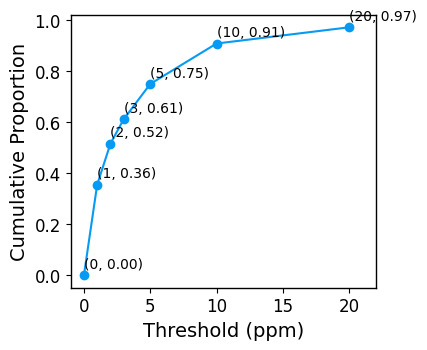

R2 = 0.96
RMSE = 6.34
MAE = 3.764304525452836


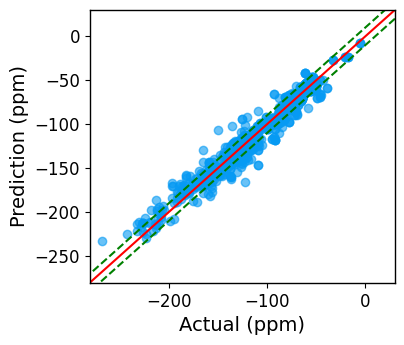

In [70]:
best_model = grid_search.best_estimator_

file_path = os.path.join("..", "artifacts", "models", f"RidgeCV_model_2d_sphere4.pkl")
with open(file_path, "wb") as file:
    pickle.dump(best_model, file)

results_table = common.get_results_table(best_model, X_train_scaled, y_train)
common.plot_prediction_performance(results_table)

common.show_results_scatter(results_table)

## 8.4 Neighboring Spheres = 5 <a class="anchor" id="8.4"></a>

In [71]:
get_2d_descriptors = atomic_features_2D.getAtomicDescriptorsFrom2DNeighbors()
train_dataset = get_2d_descriptors.getDescriptorsFromDataset(
    train_fluorinated_compounds, 5
)

dataset = common.drop_constant_col(train_dataset)
print(
    f"Shape of the training dataset after dropping out columns with constant values: {dataset.shape}"
)

dataset_dropNaN = common.drop_high_ratio_NaN_cols(dataset)
print(
    f"\nShape of the training dataset after dropping out columns with more than 80% values being NaN: {dataset_dropNaN.shape}"
)

# drop rows with NaN values in the 'NMR_Peaks' column
dataset_dropNaN = dataset_dropNaN.dropna(subset=["NMR_Peaks"])
print("\n")
print(f"-----Shape of the dataset after drop rows with NaN NMR peak values------")
print(dataset_dropNaN.shape)

# Convert all columns in df to numeric where possible, keeping non-numeric values unchanged
dataset_dropNaN = dataset_dropNaN.apply(pd.to_numeric, errors="ignore")

print(common.count_non_numeric_values(dataset_dropNaN))
# Drop categorical columns

dataset_dropCat = common.drop_categorical_columns(dataset_dropNaN)

# Conver column names to 'string'
dataset_dropCat.columns = dataset_dropCat.columns.astype(str)

dataset_dropCat, imputer = common.fill_NaN(dataset_dropCat)

file_path = os.path.join("..", "artifacts", "models", "imputer_2d_sphere5_Ridge.pkl")
with open(file_path, "wb") as file:
    pickle.dump(imputer, file)

columns = dataset_dropCat.columns.tolist()
file_path = os.path.join(
    "..", "artifacts", "models", "column_names_2d_sphere5_Ridge.pkl"
)
with open(file_path, "wb") as f:
    pickle.dump(columns, f)

print(f"\n-----Shape of the dataset after pre-processing------")
print(dataset_dropCat.shape)


dataset = dataset_dropCat.copy()
y_train = dataset["NMR_Peaks"]
X_train = dataset.drop(["NMR_Peaks"], axis=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

file_path = os.path.join("..", "artifacts", "models", f"scaler_2d_sphere5_Ridge.pkl")
with open(file_path, "wb") as file:
    pickle.dump(scaler, file)

X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = X_train.columns
X_train_scaled.index = X_train.index

param_grid = {"alpha": [5, 10, 50, 80, 90, 100, 150, 200]}

# Create the Ridge model
ridge = Ridge(fit_intercept=True)

# Initialize GridSearchCV with multiple scoring metrics
grid_search = GridSearchCV(
    estimator=ridge, param_grid=param_grid, cv=5, scoring=scoring, refit="mae"
)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best alpha and results for each metric
best_alpha = grid_search.best_params_["alpha"]
best_scores = grid_search.cv_results_


# Output the best alpha and performance on chosen metric
print(f"Best Alpha: {best_alpha}")

# Print out scoring metrics for the best model
print(f'MAE Score: {np.mean(-best_scores["mean_test_mae"]):.2f}')
print(f"Root Mean Squared Error (RMSE): {np.mean(best_scores['mean_test_rmse']):.2f}")
print(f'R^2 Score: {np.mean(best_scores["mean_test_r2"]):.2f}')

Shape of the training dataset after dropping out columns with constant values: (2351, 200)

Shape of the training dataset after dropping out columns with more than 80% values being NaN: (2351, 139)


-----Shape of the dataset after drop rows with NaN NMR peak values------
(2276, 139)
Columns with Non-Numeric Values:
Series([], dtype: int64)
None


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_1625/452947899.py:23: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  dataset_dropNaN = dataset_dropNaN.apply(pd.to_numeric, errors="ignore")



-----Shape of the dataset after pre-processing------
(2276, 139)
Best Alpha: 10
MAE Score: 4.43
Root Mean Squared Error (RMSE): 7.77
R^2 Score: 0.94


In [72]:
param_grid = {"alpha": [6, 7, 8, 9, 11, 12]}

# Initialize GridSearchCV with multiple scoring metrics
grid_search = GridSearchCV(
    estimator=ridge, param_grid=param_grid, cv=5, scoring=scoring, refit="mae"
)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best alpha and results for each metric
best_alpha = grid_search.best_params_["alpha"]
best_scores = grid_search.cv_results_


# Output the best alpha and performance on chosen metric
print(f"Best Alpha: {best_alpha}")

# Print out scoring metrics for the best model
print(f'MAE Score: {np.mean(-best_scores["mean_test_mae"]):.2f}')
print(f"Root Mean Squared Error (RMSE): {np.mean(best_scores['mean_test_rmse']):.2f}")
print(f'R^2 Score: {np.mean(best_scores["mean_test_r2"]):.2f}')

Best Alpha: 11
MAE Score: 4.34
Root Mean Squared Error (RMSE): 7.69
R^2 Score: 0.95


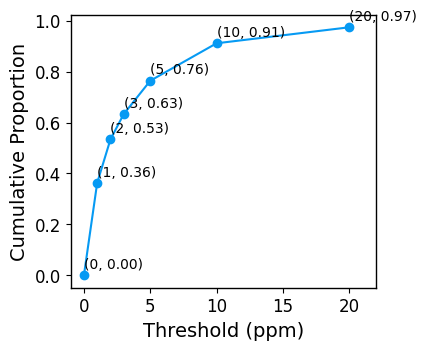

R2 = 0.96
RMSE = 6.36
MAE = 3.688523836762089


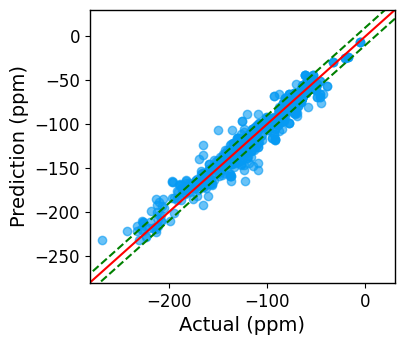

In [73]:
best_model = grid_search.best_estimator_

file_path = os.path.join("..", "artifacts", "models", f"RidgeCV_model_2d_sphere5.pkl")
with open(file_path, "wb") as file:
    pickle.dump(best_model, file)

results_table = common.get_results_table(best_model, X_train_scaled, y_train)
common.plot_prediction_performance(results_table)

common.show_results_scatter(results_table)

## 8.5 Compare Model Performance using the Validalidation Dataset <a class="anchor" id="8.5"></a>

/Users/kiluarao/ML/SCI_Project/NMR 19F/19F_NMR_Spectrum Predictor_Trainer/src/atomic_features_2D.py:566: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  content = content.apply(pd.to_numeric, errors="ignore")


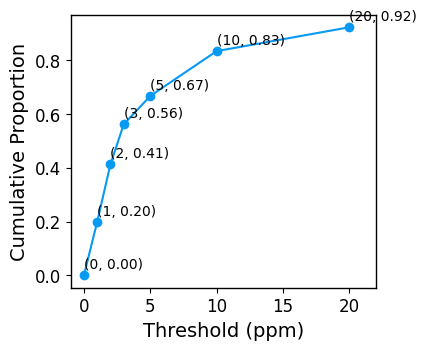

R2 = 0.89
RMSE = 9.51
MAE = 5.702055776463749


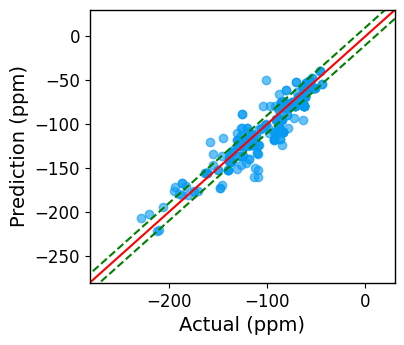

In [74]:
base_file_path = os.path.join("..", "artifacts", "models")
restuls_table = atomic_features_2D.testRidgePerformance2DFeatures(
    dataset=vali_fluorinated_compounds,
    num_spheres=2,
    RidgeCVmodel_path=os.path.join(base_file_path, "RidgeCV_model_2d_sphere2.pkl"),
    scaler_path=os.path.join(base_file_path, "scaler_2d_sphere2_Ridge.pkl"),
    imputer_path=os.path.join(base_file_path, "imputer_2d_sphere2_Ridge.pkl"),
    columns_path=os.path.join(base_file_path, "column_names_2d_sphere2_Ridge.pkl"),
)

/Users/kiluarao/ML/SCI_Project/NMR 19F/19F_NMR_Spectrum Predictor_Trainer/src/atomic_features_2D.py:566: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  content = content.apply(pd.to_numeric, errors="ignore")


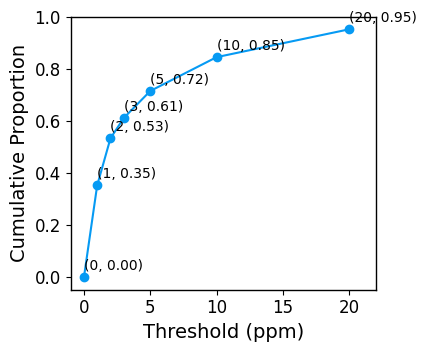

R2 = 0.92
RMSE = 8.25
MAE = 4.683960641644875


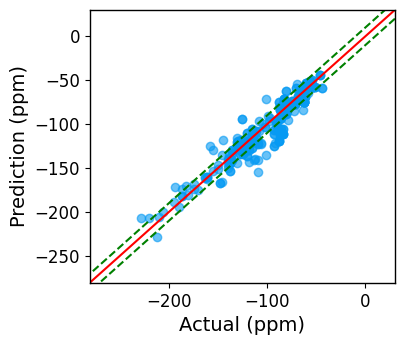

In [75]:
# sphere 3, validation dataset, get RidgeCV performance
base_file_path = os.path.join("..", "artifacts", "models")
restuls_table = atomic_features_2D.testRidgePerformance2DFeatures(
    dataset=vali_fluorinated_compounds,
    num_spheres=3,
    RidgeCVmodel_path=os.path.join(base_file_path, "RidgeCV_model_2d_sphere3.pkl"),
    scaler_path=os.path.join(base_file_path, "scaler_2d_sphere3_Ridge.pkl"),
    imputer_path=os.path.join(base_file_path, "imputer_2d_sphere3_Ridge.pkl"),
    columns_path=os.path.join(base_file_path, "column_names_2d_sphere3_Ridge.pkl"),
)

/Users/kiluarao/ML/SCI_Project/NMR 19F/19F_NMR_Spectrum Predictor_Trainer/src/atomic_features_2D.py:566: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  content = content.apply(pd.to_numeric, errors="ignore")


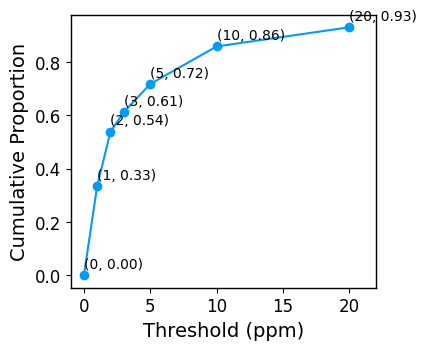

R2 = 0.91
RMSE = 8.69
MAE = 4.843271284018595


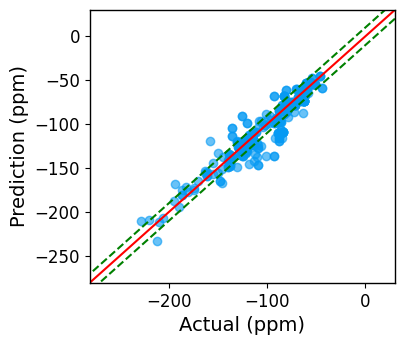

In [76]:
# sphere 4, validation dataset, get RidgeCV performance
base_file_path = os.path.join("..", "artifacts", "models")
results_table = atomic_features_2D.testRidgePerformance2DFeatures(
    dataset=vali_fluorinated_compounds,
    num_spheres=4,
    RidgeCVmodel_path=os.path.join(base_file_path, "RidgeCV_model_2d_sphere4.pkl"),
    scaler_path=os.path.join(base_file_path, "scaler_2d_sphere4_Ridge.pkl"),
    imputer_path=os.path.join(base_file_path, "imputer_2d_sphere4_Ridge.pkl"),
    columns_path=os.path.join(base_file_path, "column_names_2d_sphere4_Ridge.pkl"),
)

/Users/kiluarao/ML/SCI_Project/NMR 19F/19F_NMR_Spectrum Predictor_Trainer/src/atomic_features_2D.py:566: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  content = content.apply(pd.to_numeric, errors="ignore")


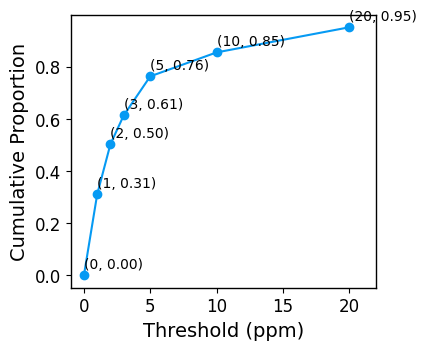

R2 = 0.93
RMSE = 7.96
MAE = 4.545161849770355


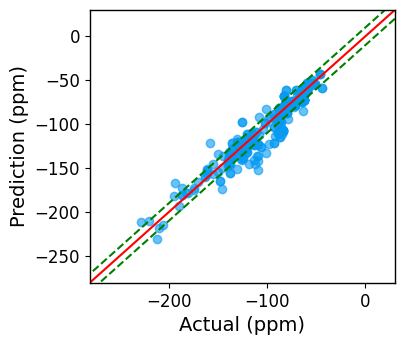

In [77]:
# sphere 5, validation dataset, get RidgeCV performance
base_file_path = os.path.join("..", "artifacts", "models")
results_table = atomic_features_2D.testRidgePerformance2DFeatures(
    dataset=vali_fluorinated_compounds,
    num_spheres=5,
    RidgeCVmodel_path=os.path.join(base_file_path, "RidgeCV_model_2d_sphere5.pkl"),
    scaler_path=os.path.join(base_file_path, "scaler_2d_sphere5_Ridge.pkl"),
    imputer_path=os.path.join(base_file_path, "imputer_2d_sphere5_Ridge.pkl"),
    columns_path=os.path.join(base_file_path, "column_names_2d_sphere5_Ridge.pkl"),
)

In [78]:
# save results table
file_path = os.path.join("..", "artifacts", "results")
results_table.to_csv(
    os.path.join(file_path, "RidgeCV_2DFeatureSet_sphere5_valiDataset.csv")
)

Results: The best performing model used features of atoms from the nearest **five** spheres in 2D space.

## 8.6 Feature Importance Analysis <a class="anchor" id="8.6"></a>

In [79]:
get_2d_descriptors = atomic_features_2D.getAtomicDescriptorsFrom2DNeighbors()
train_dataset = get_2d_descriptors.getDescriptorsFromDataset(
    train_fluorinated_compounds, 5
)

dataset = common.drop_constant_col(train_dataset)
print(
    f"Shape of the training dataset after dropping out columns with constant values: {dataset.shape}"
)

dataset_dropNaN = common.drop_high_ratio_NaN_cols(dataset)
print(
    f"\nShape of the training dataset after dropping out columns with more than 80% values being NaN: {dataset_dropNaN.shape}"
)

# drop rows with NaN values in the 'NMR_Peaks' column
dataset_dropNaN = dataset_dropNaN.dropna(subset=["NMR_Peaks"])
print("\n")
print(f"-----Shape of the dataset after drop rows with NaN NMR peak values------")
print(dataset_dropNaN.shape)

# Convert all columns in df to numeric where possible, keeping non-numeric values unchanged
dataset_dropNaN = dataset_dropNaN.apply(pd.to_numeric, errors="ignore")

print(common.count_non_numeric_values(dataset_dropNaN))

# Drop categorical columns
dataset_dropCat = common.drop_categorical_columns(dataset_dropNaN)

# Conver column names to 'string'
dataset_dropCat.columns = dataset_dropCat.columns.astype(str)

dataset_dropCat, imputer = common.fill_NaN(dataset_dropCat)

Shape of the training dataset after dropping out columns with constant values: (2351, 200)

Shape of the training dataset after dropping out columns with more than 80% values being NaN: (2351, 139)


-----Shape of the dataset after drop rows with NaN NMR peak values------
(2276, 139)
Columns with Non-Numeric Values:
Series([], dtype: int64)
None


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_1625/4022907222.py:23: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  dataset_dropNaN = dataset_dropNaN.apply(pd.to_numeric, errors="ignore")


In [80]:
dataset = dataset_dropCat.copy()
correlation_matrix = dataset.corr()

# Set a threshold for high correlation
threshold = 0.95

columns_to_drop = set()

# Find pairs of highly correlated columns
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            columns_to_drop.add(colname)  # Add one column of the pair to the set

# Drop one of each highly correlated pair
dataset_reduced = dataset.drop(columns=columns_to_drop)
dataset_reduced.shape

(2276, 103)

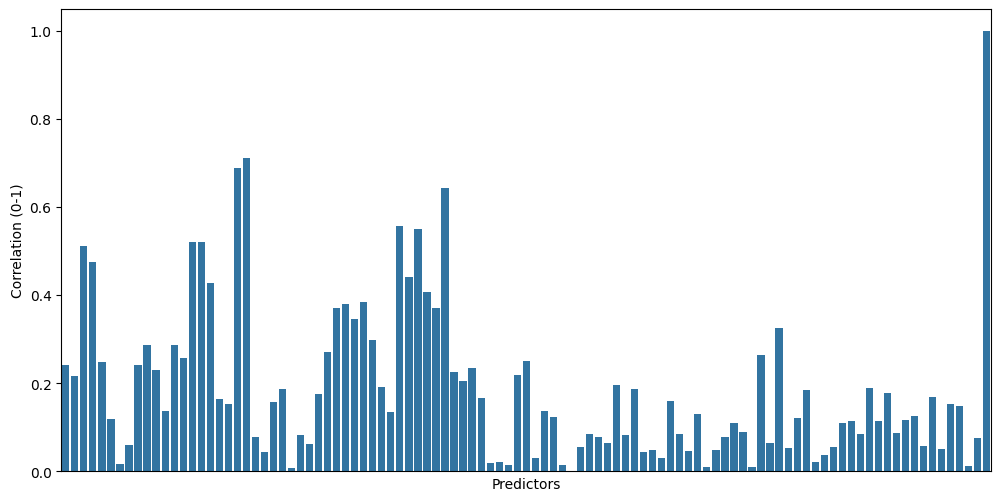

In [81]:
# Correlation between variables
data = dataset_reduced
data["NMR_Peaks"] = pd.to_numeric(data["NMR_Peaks"], errors="coerce")
corr = data.corr(numeric_only=True)["NMR_Peaks"].abs()

f, ax = plt.subplots(figsize=(12, 6))

sns.barplot(y=corr, x=corr.index, ax=ax)
ax.set_xlabel("Predictors")
ax.set_xticklabels("")
ax.set_xticks([])
ax.set_ylabel("Correlation (0-1)")
plt.show()

In [82]:
print(corr[corr > 0.6])
print(corr[corr > 0.6].index.values)

24           0.690658
25           0.711484
52           0.644349
NMR_Peaks    1.000000
Name: NMR_Peaks, dtype: float64
['24' '25' '52' 'NMR_Peaks']
